# Setup

In [1]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
# %pip install umap-learn


In [2]:
!pip install tqdm

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 wi

In [7]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4090
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [8]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"

    Excludes any file containing "br_raw" in its path and logs all skipped folders.

    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []

    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }

    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")

    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.

    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.

    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)

    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


## Data Ingestion

In [1]:
!pip install pydicom
!pip install nibabel

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 wi

In [9]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.

    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")

    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)

    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept

    return pixel_array, ds

In [10]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "/data/Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")


Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


## Data Visualization

Loading file for group PD: /data/Images/PPMI_Images_PD/3359/Reconstructed_DaTSCAN/2013-09-04_12_03_35.0/I419866/PPMI_3359_NM_Reconstructed_DaTSCAN_Br_20140411094504501_1_S215955_I419866.dcm
Loading file for group SWEDD: /data/Images/PPMI_Images_SWEDD/3871/Reconstructed_DaTSCAN/2013-04-17_13_55_59.0/I388554/PPMI_3871_NM_Reconstructed_DaTSCAN_Br_20130909140103767_1_S190851_I388554.dcm
Loading file for group Control: /data/Images/PPMI_Images_Cont/137499/Reconstructed_DaTSCAN/2022-05-17_14_50_04.0/I1601749/PPMI_137499_NM_Reconstructed_DaTSCAN_Br_20220706100152512_1_S1145370_I1601749.dcm


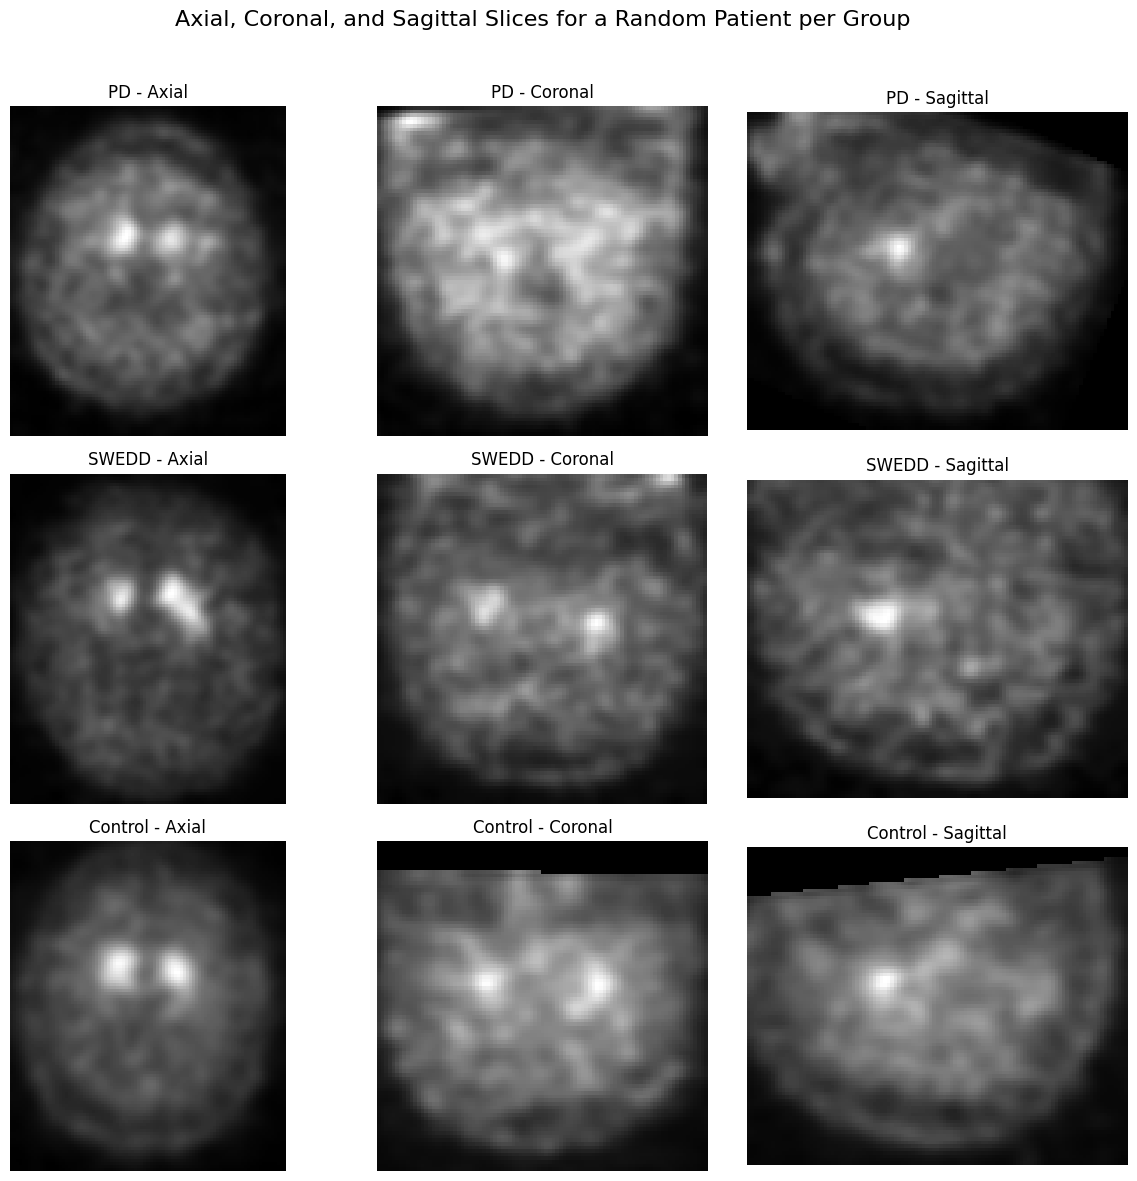

In [11]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}
maskH = nib.load('rmask_ICV.nii')
mask = maskH.get_fdata()>0.5
mask = np.transpose(mask,[2, 1, 0])
mask = np.flip(mask,axis=1)
# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue

    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")

    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)

    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")

    axial, coronal, sagittal = extract_slices(volume)

    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")

    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")

    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Data Preprocessing

### Intensity Normalization and Volume Preprocessing

### Brain Masking

In [8]:
!pip install scikit-image

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 wi

(64, 109, 91)
(64, 128, 128)


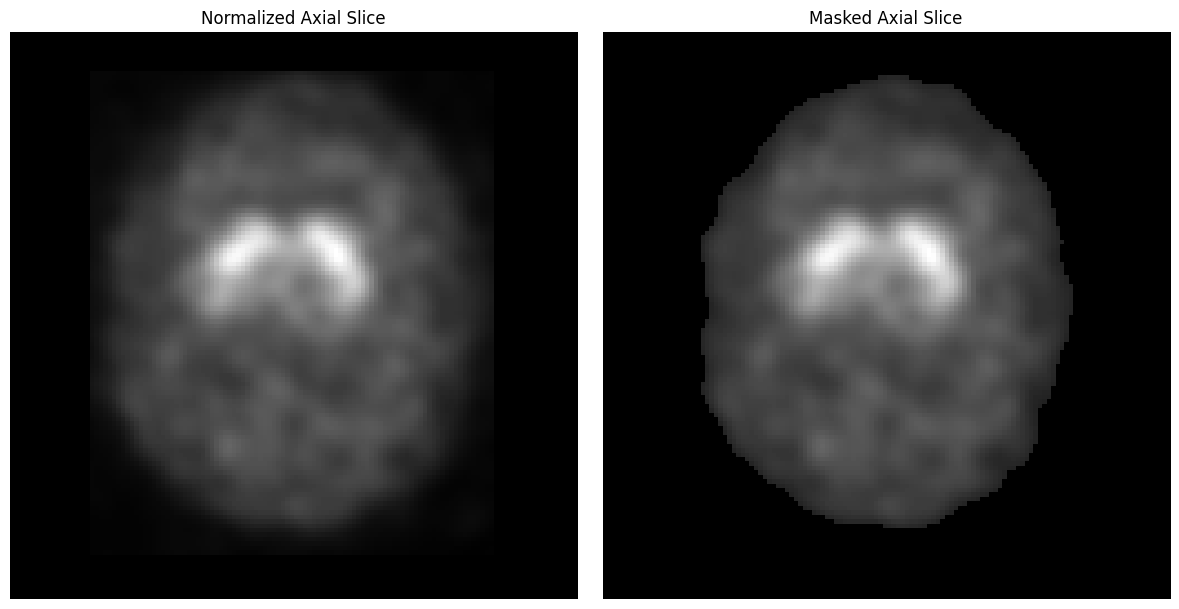

In [12]:
# Cell 8: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

def resize_volume(volume, target_shape=(64, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.

    Args:
        volume: Input 3D volume as numpy array with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)

    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after

    current_shape = volume.shape
    resized = volume.copy()

    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]

    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )

    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            # Calculate slicing indices
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            # Apply slice
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]

    return resized

def process_volume(volume, target_shape=(64, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding and morphological closing

    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (depth, height, width)

    Returns:
        norm_vol: Normalized and resized volume
        mask: Brain mask
        masked_vol: Masked volume
    """
    # 1. Intensity normalization
    # volume = np.clip(volume, a_min=0, a_max=None)
    # vmin, vmax = volume.min(), volume.max()
    # if vmax > vmin:
    #     norm_vol = (volume - vmin) / (vmax - vmin)
    # else:
    #     norm_vol = volume - vmin
    

    # 2. Resize the normalized volume
    norm_vol = resize_volume(volume-volume.min(), target_shape=target_shape)
    mask = np.zeros((64,128,128),dtype=bool)
    mask[20:40,82:103,43:82]=1    
    norm_vol /= np.mean(norm_vol[mask])    

    # 3. Compute brain mask
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)
original_volume = original_volume[9:73,:,:]

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(64,128,128))

print(original_volume.shape)
print(norm_vol.shape)

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


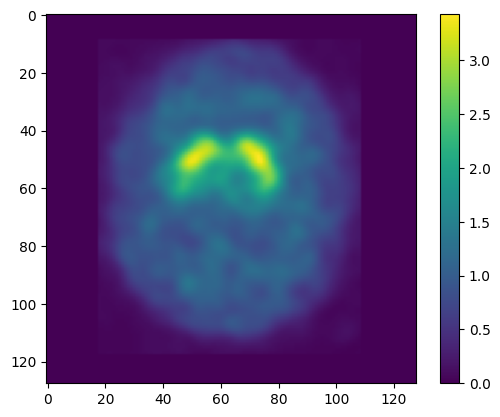

In [13]:
plt.imshow(norm_vol[32,:,:])
plt.colorbar()



## Dataloader Creation (with Shape Validation)

In [10]:
!pip install ipywidgets

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 wi

In [14]:
# Cell 9: Dataset Implementation with Shape Validation
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import gc
import numpy as np
import os
import psutil
from sklearn.model_selection import train_test_split


def print_memory_stats():
    """Print memory usage statistics"""
    if torch.cuda.is_available():
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")



### LP Ram Loader

In [15]:
class LPRamDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        maskH = nib.load('rmask_ICV.nii')
        mask = maskH.get_fdata()>0.5
        mask = np.transpose(mask,[2, 1, 0])
        mask = np.flip(mask,axis=1)        
        self.npArr = np.zeros((len(dataframe),1,64,128,128),dtype=np.float32)

        counter=0
        for _, row in dataframe.iterrows():
            try:
                file_path = row["file_path"]

            # Load DICOM
                volume, _ = load_dicom(file_path) 
                volume -= volume.min()
         #       print(counter)
         #       print(volume.shape)
        #        print(mask.shape)
                volume *= mask
                norm_vol, _, masked_vol = process_volume(volume[9:73,:,:], target_shape=(64, 128, 128))
                self.npArr[counter,0,:,:,:]=norm_vol
                counter +=1
           #     delete volume, norm_vol, masked_vol
            except Exception as e:
                print(f"Error processing file {row['file_path']}: {e}") 
        self.npArr = self.npArr[:counter,:,:,:,:]
 #       self.immArr = torch.from_numpy(self.npArr).float().to("cuda")        
  #      delete volume, masked_vol, mask
        gc.collect()

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
      #      print(self.immArr.shape)
 #           print(idx)
            volume_tensor = torch.from_numpy(self.npArr[idx, :, :, :, :])
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path":self.df.iloc[idx]["file_path"]
            }


def create_dataloaders(df, batch_size=4, train_split=0.8):
    """Create train and validation dataloaders with stratified split"""
    # Stratified split to maintain group distributions
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # No multiprocessing for debugging
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # No multiprocessing for debugging
        pin_memory=True
    )

    return train_loader, val_loader


# Exploratory Data Analysis (EDA)

In [13]:
!pip install seaborn

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 wi

Creating stratified dataloaders...

Dataset split statistics:
Training set distribution:
label
PD         2035
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         510
Control     59
SWEDD       27
Name: count, dtype: int64
Starting Exploratory Data Analysis...

Analyzing training dataset...
Analyzing dataset statistics...


Computing statistics:   0%|          | 0/149 [00:00<?, ?it/s]


Plotting intensity distributions...


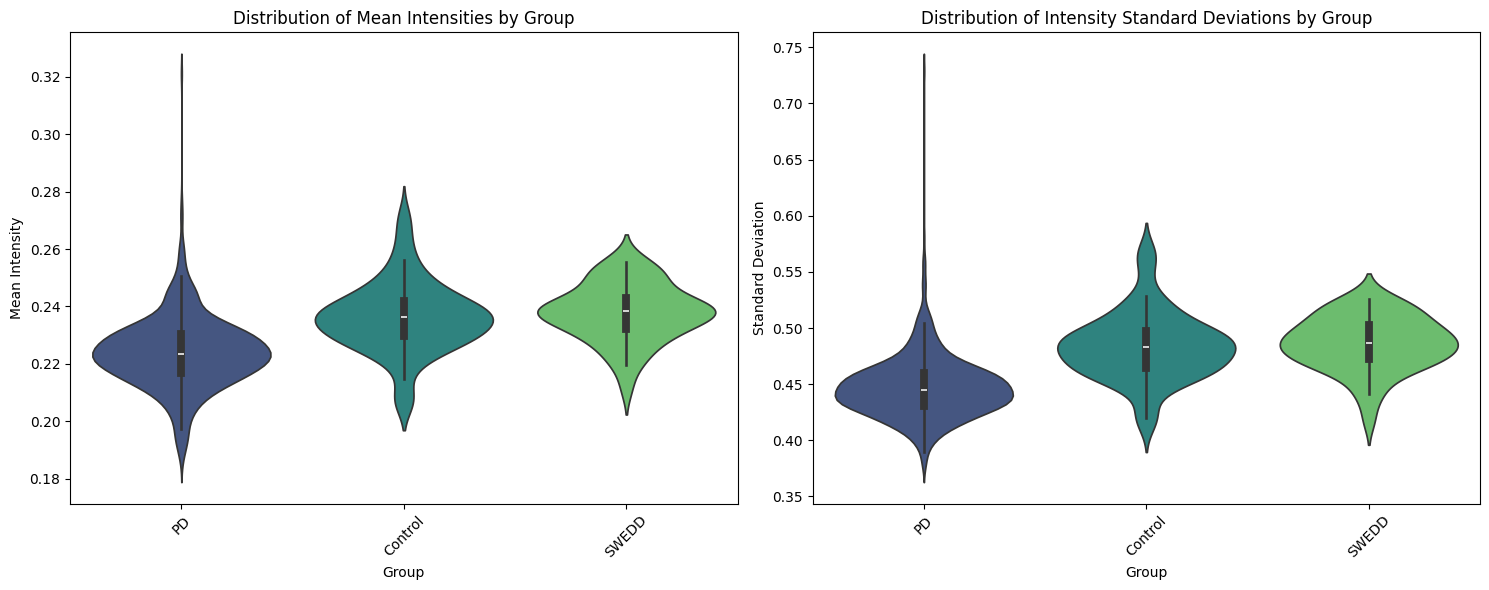


Plotting group statistics...


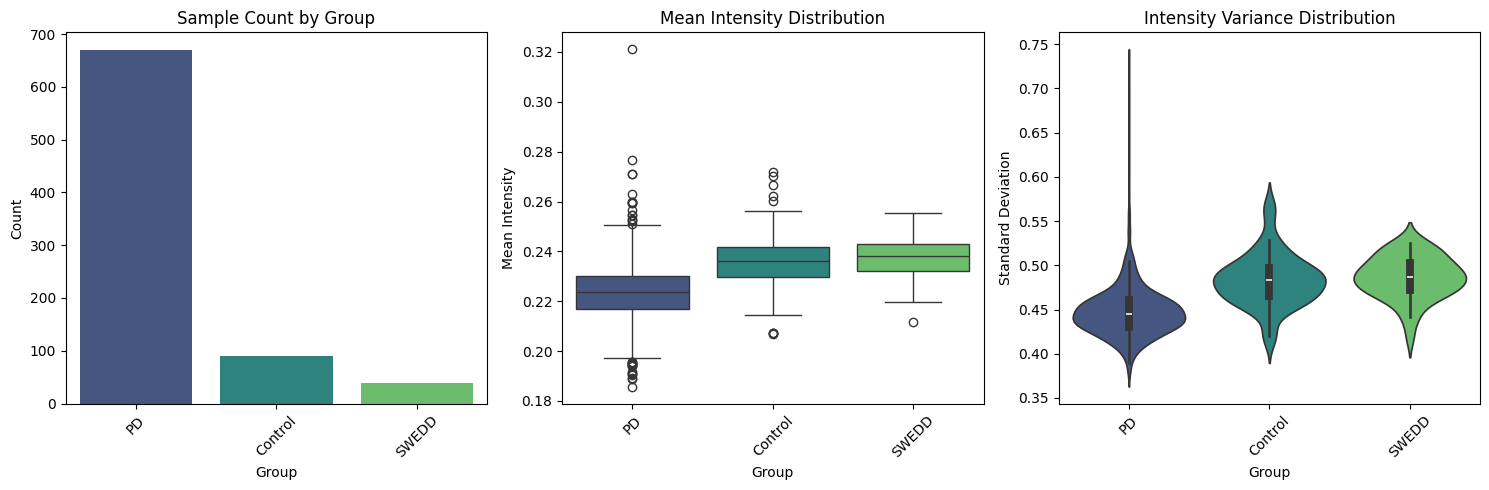


Analyzing spatial patterns...


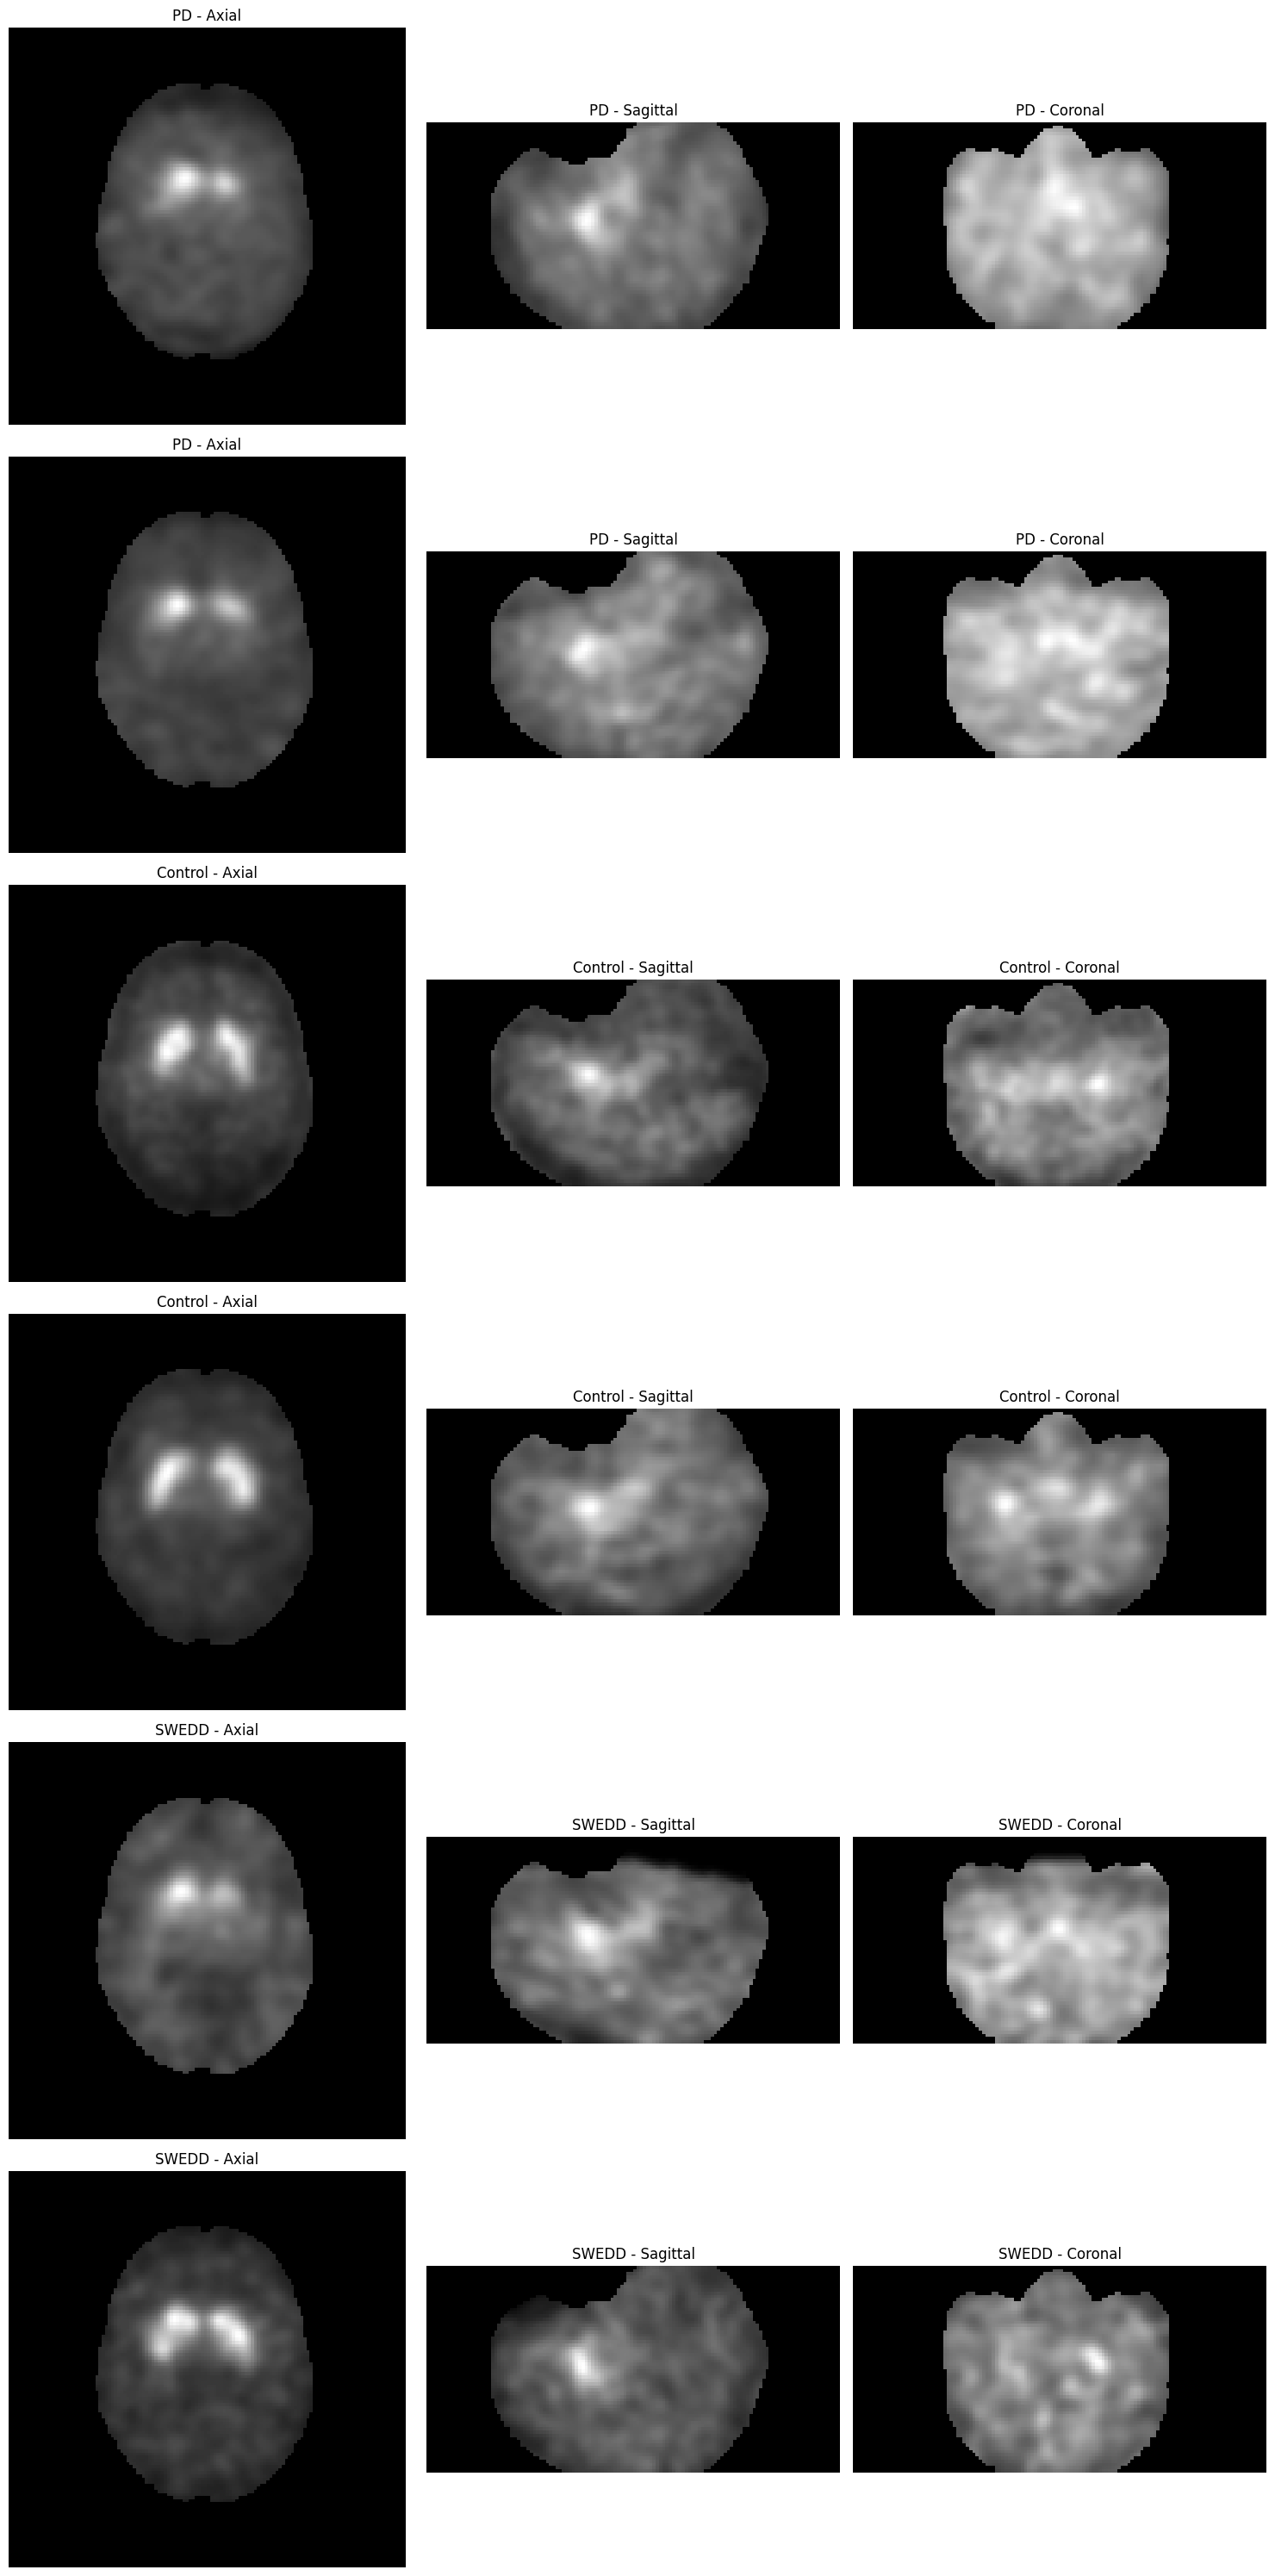


Summary Statistics by Group:
          mean           std        median       min         max       
          mean    std   mean    std   mean  std mean  std   mean    std
label                                                                  
Control  0.236  0.012  0.484  0.030    0.0  0.0  0.0  0.0  5.068  0.835
PD       0.224  0.013  0.447  0.028    0.0  0.0  0.0  0.0  3.736  0.927
SWEDD    0.238  0.010  0.486  0.024    0.0  0.0  0.0  0.0  4.980  0.775

EDA completed!


In [16]:
# Cell 10: Comprehensive EDA Implementation with Stratified Split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split

# First, let's implement proper stratified splitting
def create_stratified_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with stratified splitting to maintain class distributions
    """
    # Perform stratified split
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nDataset split statistics:")
    print("Training set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets
    train_dataset = LPRamDataset(train_df)
    val_dataset = LPRamDataset(val_df)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=6,
        prefetch_factor=6,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=6,
        prefetch_factor=6,        
        pin_memory=True
    )

    return train_loader, val_loader

def analyze_dataset_statistics(dataloader, num_batches=None):
    """
    Analyzes dataset statistics with memory-efficient batch processing
    Returns: Dictionary of statistical measures
    """
    print("Analyzing dataset statistics...")
    stats = defaultdict(list)

    try:
        for i, batch in enumerate(tqdm(dataloader, desc="Computing statistics")):
            if num_batches and i >= num_batches:
                break

            volumes = batch['volume']
            labels = batch['label']
            path = batch['path']

            # Per-volume statistics
            for vol_idx, (volume, label) in enumerate(zip(volumes, labels)):
                vol_data = volume.numpy().flatten()

                stats['mean'].append(np.mean(vol_data))
                stats['std'].append(np.std(vol_data))
                stats['median'].append(np.median(vol_data))
                stats['min'].append(np.min(vol_data))
                stats['max'].append(np.max(vol_data))
                stats['label'].append(label)
                stats['path'].append(path[vol_idx])

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during statistical analysis: {str(e)}")
        import traceback
        traceback.print_exc()

    return pd.DataFrame(stats)

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))

    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group
    """
    plt.figure(figsize=(15, 5))

    # Group counts
    plt.subplot(1, 3, 1)
    sns.countplot(data=stats_df, x='label', palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Box plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    # Violin plots for variance
    plt.subplot(1, 3, 3)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_spatial_patterns(dataloader, num_samples_per_group=2):
    """
    Analyzes spatial patterns in the volumes, ensuring samples from each group
    """
    # Collect samples per group
    samples = defaultdict(list)

    print("Collecting samples for spatial analysis...")
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        

        for volume, label in zip(volumes, labels):
            if len(samples[label]) < num_samples_per_group:
                samples[label].append(volume)

        # Check if we have enough samples from each group
        if all(len(v) >= num_samples_per_group for v in samples.values()):
            break

    # Plot samples
    total_samples = len(samples) * num_samples_per_group
    plt.figure(figsize=(15, 5 * total_samples))

    plot_idx = 1
    for label in samples:
        for volume in samples[label]:
            # Get middle slices
            vol_data = volume.squeeze().numpy()
            axial = vol_data[vol_data.shape[0]//2, :, :]
            sagittal = vol_data[:, :, vol_data.shape[2]//2]
            coronal = vol_data[:, vol_data.shape[1]//2, :]

            # Plot
            plt.subplot(total_samples, 3, plot_idx)
            plt.imshow(axial, cmap='gray')
            plt.title(f'{label} - Axial')
            plt.axis('off')

            plt.subplot(total_samples, 3, plot_idx + 1)
            plt.imshow(sagittal, cmap='gray')
            plt.title(f'{label} - Sagittal')
            plt.axis('off')

            plt.subplot(total_samples, 3, plot_idx + 2)
            plt.imshow(coronal, cmap='gray')
            plt.title(f'{label} - Coronal')
            plt.axis('off')

            plot_idx += 3

    plt.tight_layout()
    plt.show()

# Create new stratified dataloaders
print("Creating stratified dataloaders...")
train_loader, val_loader = create_stratified_dataloaders(df, batch_size=16)

# Run the EDA
print("Starting Exploratory Data Analysis...")

# Analyze training dataset statistics
print("\nAnalyzing training dataset...")
train_stats = analyze_dataset_statistics(train_loader, num_batches=50)

# Plot distributions
print("\nPlotting intensity distributions...")
plot_intensity_distributions(train_stats)

# Plot group statistics
print("\nPlotting group statistics...")
plot_group_statistics(train_stats)

# Analyze spatial patterns
print("\nAnalyzing spatial patterns...")
analyze_spatial_patterns(train_loader, num_samples_per_group=2)

# Print summary statistics
print("\nSummary Statistics by Group:")
summary_stats = train_stats.groupby('label').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'median': ['mean', 'std'],
    'min': ['mean', 'std'],
    'max': ['mean', 'std']
}).round(3)
print(summary_stats)

# Memory cleanup
gc.collect()
torch.cuda.empty_cache()
print("\nEDA completed!")

### Slice Intensity Variance Analysis

In [16]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")

    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}

    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']

            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()

                if sample_counts[label] >= num_samples_per_group:
                    continue

                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape

                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]

                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)

                sample_counts[label] += 1

            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0)
            for view, variances in group_variances[group].items()
        }

    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, view in enumerate(views):
        ax = axes[idx]

        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)

        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   0%|          | 0/149 [00:00<?, ?it/s]


Plotting slice-wise variance analysis...


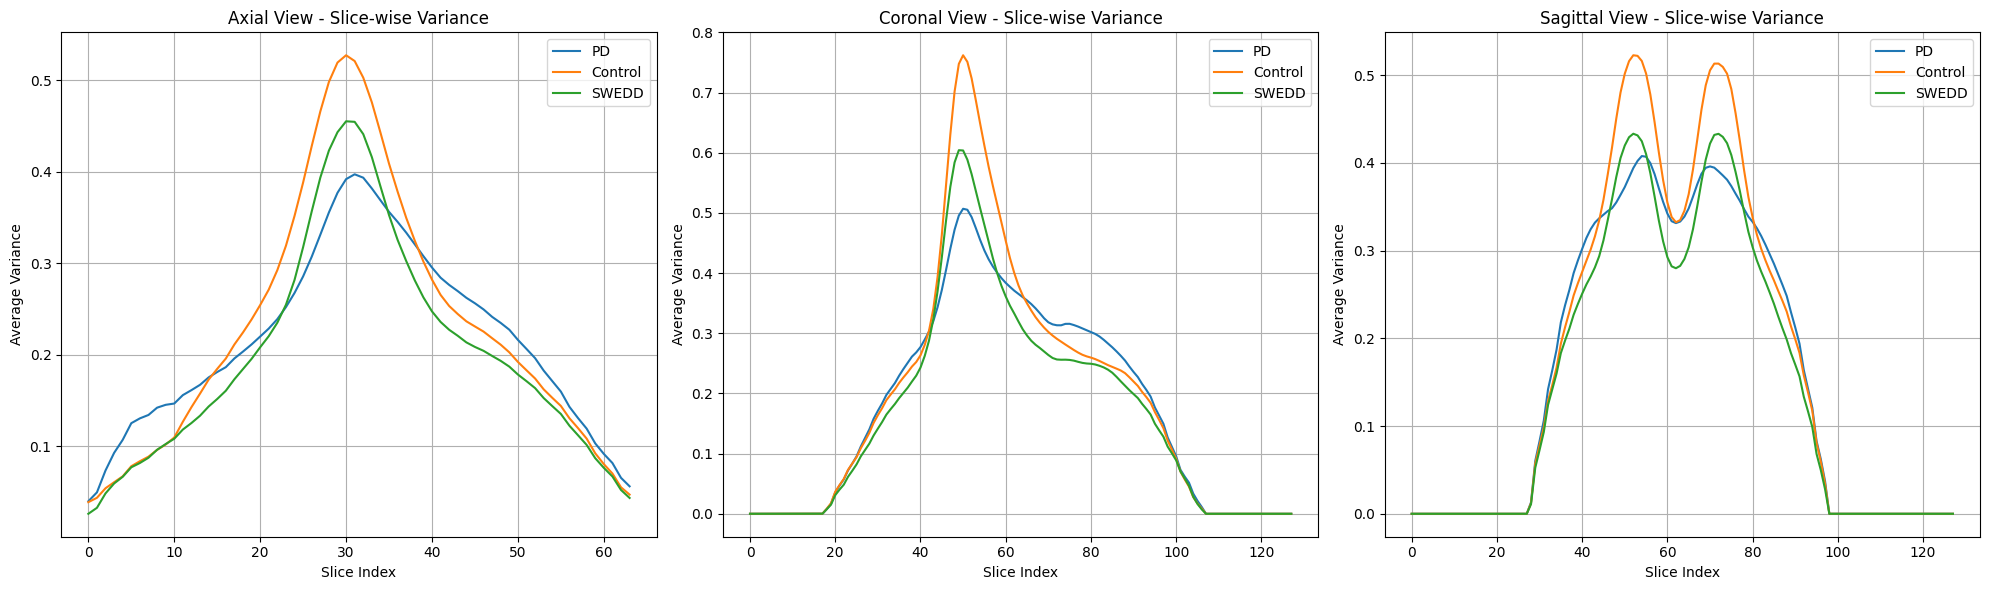

In [17]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model Phase

In [18]:
# Memory and Batch Size Optimization test control

def test_batch_memory_limits(data_loader, start_size=8, max_size=48, step=8):
    """
    Tests different batch sizes to find the optimal one that maximizes GPU utilization
    while avoiding out-of-memory errors.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    memory_stats = {}
    optimal_batch_size = start_size

    print("Starting batch size optimization test...")
    print(f"Testing batch sizes from {start_size} to {max_size} in steps of {step}")
    print("\nYour GPU: NVIDIA RTX 4070 Ti (12GB)")
    print("Current test will estimate memory headroom for both training and inference\n")

    # Get a single batch from the data loader to understand the data shape
    sample_batch = next(iter(data_loader))
    sample_volume = sample_batch['volume']
    volume_shape = sample_volume.shape[1:]
    print(f"Volume shape (excluding batch dimension): {volume_shape}")

    for batch_size in range(start_size, max_size + step, step):
        try:
            print(f"\nTesting batch size: {batch_size}")

            # Create a dummy batch with gradient tracking
            dummy_data = torch.randn(batch_size, *volume_shape, device=device, requires_grad=True)

            # Simulate model operations (more intensive to better represent real usage)
            conv_weight1 = torch.randn(32, 1, 3, 3, 3, device=device, requires_grad=True)
            conv_weight2 = torch.randn(64, 32, 3, 3, 3, device=device, requires_grad=True)

            # Forward operations (more complex to better simulate real model)
            conv1 = torch.nn.functional.conv3d(dummy_data, conv_weight1, padding=1)
            act1 = torch.nn.functional.relu(conv1)
            pool1 = torch.nn.functional.max_pool3d(act1, kernel_size=2)

            conv2 = torch.nn.functional.conv3d(pool1, conv_weight2, padding=1)
            act2 = torch.nn.functional.relu(conv2)
            pool2 = torch.nn.functional.max_pool3d(act2, kernel_size=2)

            loss = pool2.mean()
            loss.backward()

            # Get memory statistics
            allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
            reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB
            max_memory = 20 * 1024  # 12GB for RTX 4070 Ti
            memory_usage_percent = (reserved / max_memory) * 100

            memory_stats[batch_size] = {
                'allocated': allocated,
                'reserved': reserved,
                'usage_percent': memory_usage_percent
            }

            print(f"GPU Memory Allocated: {allocated:.2f} MB")
            print(f"GPU Memory Reserved: {reserved:.2f} MB")
            print(f"Total GPU Memory Usage: {memory_usage_percent:.1f}%")

            # Estimate training headroom
            headroom = max_memory - reserved
            print(f"Estimated memory headroom: {headroom:.2f} MB")

            # Update optimal batch size
            optimal_batch_size = batch_size

            # Clean up
            del dummy_data, conv_weight1, conv_weight2, conv1, conv2, act1, act2, pool1, pool2, loss
            torch.cuda.empty_cache()

            # If we're using more than 70% of GPU memory, stop testing
            if memory_usage_percent > 70:
                print("\nReaching high memory usage, stopping tests for safety")
                break

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\nOut of memory at batch size {batch_size}")
                print(f"Last successful batch size was {optimal_batch_size}")
                break
            else:
                print(f"Unexpected error: {str(e)}")
                break

    # Calculate recommended values based on memory usage pattern
    recommended_batch_size = int(optimal_batch_size * 0.8)  # 80% of max for safety
    recommended_accum_steps = 2 if recommended_batch_size >= 16 else 4

    print("\nBatch Size Optimization Results:")
    print(f"Maximum tested batch size: {optimal_batch_size}")
    print(f"Recommended batch size for training: {recommended_batch_size}")
    print(f"Recommended accumulation steps: {recommended_accum_steps}")
    print("\nRecommended training configuration:")
    print(f"config = TrainingConfig(")
    print(f"    batch_size={recommended_batch_size},")
    print(f"    accumulation_steps={recommended_accum_steps},")
    print(f"    use_mixed_precision=True,")
    print(f"    num_workers=4,")
    print(f"    pin_memory=True")
    print(f")")

    return recommended_batch_size, memory_stats

# Example usage
if __name__ == "__main__":
    try:
        print("\nTesting optimal batch size configuration...")
        optimal_batch_size, memory_stats = test_batch_memory_limits(train_loader)
    except Exception as e:
        print(f"Error during batch size testing: {str(e)}")
        print("Using default conservative values:")
        print("batch_size = 8")
        print("accumulation_steps = 4")


Testing optimal batch size configuration...
Starting batch size optimization test...
Testing batch sizes from 8 to 48 in steps of 8

Your GPU: NVIDIA RTX 4070 Ti (12GB)
Current test will estimate memory headroom for both training and inference

Volume shape (excluding batch dimension): torch.Size([1, 64, 128, 128])

Testing batch size: 8
GPU Memory Allocated: 2784.43 MB
GPU Memory Reserved: 3876.00 MB
Total GPU Memory Usage: 18.9%
Estimated memory headroom: 16604.00 MB

Testing batch size: 16
GPU Memory Allocated: 5568.43 MB
GPU Memory Reserved: 9862.00 MB
Total GPU Memory Usage: 48.2%
Estimated memory headroom: 10618.00 MB

Testing batch size: 24
GPU Memory Allocated: 8352.43 MB
GPU Memory Reserved: 14790.00 MB
Total GPU Memory Usage: 72.2%
Estimated memory headroom: 5690.00 MB

Reaching high memory usage, stopping tests for safety

Batch Size Optimization Results:
Maximum tested batch size: 24
Recommended batch size for training: 19
Recommended accumulation steps: 2

Recommended tra

## 1. Autoencoder

### Model Setup

In [19]:
# Cell 11: Base Autoencoder Implementation with Memory Optimization
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

import torch.cuda.amp as amp

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    """3D Encoder network optimized for 128³ input volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent space
        self.flatten_size = 256 * 8 * 8 * 4
        self.fc = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Track shapes for debugging
      #  if self.training:
      #      print(f"Input shape: {x.shape}")

        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)

    #    if self.training:
    #        print(f"Latent shape: {z.shape}")

        return z #(d1, d2, d3, d4)

class Decoder(nn.Module):
    """3D Decoder network optimized for 128³ output volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 8 * 8 * 4
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path with skip connections
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(256,128),
          #  nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            #nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),   # 16 -> 32
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(128,64),
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
           # nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 32 -> 64
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(64,32),
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            #nn.ConvTranspose3d(16, 16, kernel_size=2, stride=2),    # 64 -> 128
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(32,16),
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z): #, skip_connections):
    #    if self.training:
      #      print(f"Decoder input shape: {z.shape}")

        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)

        # Unpack skip connections
    #    d1, d2, d3, d4 = skip_connections

        # Upsampling with skip connections
        x = self.up1(x) #+ d4)
        x = self.up2(x) #+ d3)
        x = self.up3(x) #+ d2)
        x = self.up4(x) #+ d1)

        # Final convolution with sigmoid activation
        x = (self.final_conv(x))

   #     if self.training:
#            print(f"Output shape: {x.shape}")

        return x

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder for 128³ medical volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        #z, skip_connections = self.encoder(x)
        z = self.encoder(x)
        reconstruction = self.decoder(z) #, skip_connections)
        return reconstruction

    def encode(self, x):
        """Encode input to latent space"""
        #z, _ = self.encoder(x)
        z = self.encoder(x)
        return z

    def decode(self, z):
        """Decode from latent space (for generation)"""
        batch_size = z.size(0)
        device = z.device
        dummy_skips = (
            torch.zeros(batch_size, 32, 64, 64, 64, device=device),
            torch.zeros(batch_size, 64, 32, 32, 32, device=device),
            torch.zeros(batch_size, 128, 16, 16, 16, device=device),
            torch.zeros(batch_size, 256, 8, 8, 8, device=device)
        )
        return self.decoder(z, dummy_skips)

def test_autoencoder(batch_size=4):
    """Test the autoencoder with dummy data and verify memory usage."""
    print("\nTesting Autoencoder Architecture...")

    try:
        # Create model and move to GPU
        model = BaseAutoencoder()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Print model summary
        print("\nModel Architecture:")
        print(model)

        # Create dummy input (128³ volume)
        dummy_input = torch.randn(batch_size, 1, 64, 128, 128, device=device)

        # Print initial memory usage
        print("\nInitial GPU Memory Usage:")
        print_gpu_memory_stats()

        # Test forward pass
        print("\nTesting forward pass...")
        encOut = model.encode(dummy_input)
        print(f"\nencoder shape: {encOut.shape}")
        with torch.no_grad():
            output = model(dummy_input)

        # Print output shape and final memory usage
        print(f"\nOutput shape: {output.shape}")
        print("\nFinal GPU Memory Usage:")
        print_gpu_memory_stats()

        # Verify shapes
        assert output.shape == dummy_input.shape, f"Shape mismatch: {output.shape} vs {dummy_input.shape}"

        # Clean up
        del model, dummy_input, output
        torch.cuda.empty_cache()

        print("\nAutoencoder test completed successfully!")

    except Exception as e:
        print(f"Error testing autoencoder: {str(e)}")
        import traceback
        traceback.print_exc()

# Run test if this cell is executed
if __name__ == "__main__":
    test_autoencoder()


Testing Autoencoder Architecture...

Model Architecture:
BaseAutoencoder(
  (encoder): Encoder(
    (init_conv): ConvBlock(
      (block): Sequential(
        (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (down1): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
      )


In [20]:
# Cell 12: Training Utilities and Configuration
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TrainingConfig:
    """Training configuration optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.batch_size = kwargs.get('batch_size', 8)  # Increased from 2 to 8
        self.accumulation_steps = kwargs.get('accumulation_steps', 4)  # New: gradient accumulation
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 10)
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'autoencoder')
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)  # Enable by default
        self.num_workers = kwargs.get('num_workers', 4)  # Optimize data loading
        self.pin_memory = kwargs.get('pin_memory', True)  # Faster data transfer to GPU

        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class EarlyStopping:
    """Early stopping handler with patience"""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.should_stop

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses):
        """Save model checkpoint and training metadata"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, self.checkpoint_path)

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer, scheduler):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }

def print_gpu_memory_stats():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")

In [21]:
# Cell 13: Training Loop Implementation
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train_autoencoder(model, train_loader, val_loader, config=None):
    """GPU-optimized training loop with mixed precision and gradient accumulation"""
    if config is None:
        config = TrainingConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize training components
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Load checkpoint if available
    start_epoch = 0
    train_losses = []
    val_losses = []
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            model.train()
            epoch_loss = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Train]')

            for batch_idx, batch in enumerate(train_pbar):
          #      print (batch_idx)
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)
          
           #         print(volumes.shape)
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed = model(volumes)
            #            print(reconstructed.shape)
                        loss = criterion(reconstructed, volumes)
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    epoch_loss += loss.item() * config.accumulation_steps
                    train_pbar.set_postfix({'loss': loss.item() * config.accumulation_steps})
                    
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Adjusting batch size...")
                        torch.cuda.empty_cache()
                        continue
                    raise e

                # Clean up
                del volumes, reconstructed, loss
                torch.cuda.empty_cache()

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{config.epochs} [Val]')

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        val_loss += loss.item()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'reconstructed' in locals():
                                del reconstructed
                            if 'loss' in locals():
                                del loss
                            torch.cuda.empty_cache()
                            continue
                        else:
                            raise e

                    # Clean up
                    del volumes, reconstructed, loss
                    torch.cuda.empty_cache()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{config.epochs}")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print_gpu_memory_stats()

            # Early stopping check
            if early_stopping(avg_val_loss):
                print("\nEarly stopping triggered!")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        return train_losses, val_losses

### Training

Epoch 1/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 1/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 1/300
Train Loss: 0.019581
Val Loss: 0.011372
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 2/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 2/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 2/300
Train Loss: 0.008796
Val Loss: 0.007943
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 3/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 3/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 3/300
Train Loss: 0.007253
Val Loss: 0.007146
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 4/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 4/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 4/300
Train Loss: 0.006513
Val Loss: 0.006913
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 5/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 5/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 5/300
Train Loss: 0.006116
Val Loss: 0.005685
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 6/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 6/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 6/300
Train Loss: 0.005715
Val Loss: 0.021984
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 7/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 7/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 7/300
Train Loss: 0.005765
Val Loss: 0.005460
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 8/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 8/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 8/300
Train Loss: 0.005293
Val Loss: 0.005345
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 9/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 9/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 9/300
Train Loss: 0.005152
Val Loss: 0.005532
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 10/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 10/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 10/300
Train Loss: 0.005052
Val Loss: 0.005192
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 11/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 11/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 11/300
Train Loss: 0.004907
Val Loss: 0.004908
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 12/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 12/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 12/300
Train Loss: 0.004800
Val Loss: 0.005492
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 13/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 13/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 13/300
Train Loss: 0.004735
Val Loss: 0.004910
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 14/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 14/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 14/300
Train Loss: 0.004607
Val Loss: 0.004623
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 15/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 15/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 15/300
Train Loss: 0.004564
Val Loss: 0.005261
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 16/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 16/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 16/300
Train Loss: 0.004641
Val Loss: 0.006149
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 17/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 17/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 17/300
Train Loss: 0.004407
Val Loss: 0.004565
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 18/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 18/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 18/300
Train Loss: 0.004355
Val Loss: 0.004442
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 19/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 19/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 19/300
Train Loss: 0.004247
Val Loss: 0.005944
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 20/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 20/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 20/300
Train Loss: 0.004254
Val Loss: 0.004184
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 21/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 21/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 21/300
Train Loss: 0.004193
Val Loss: 0.004197
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 22/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 22/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 22/300
Train Loss: 0.004160
Val Loss: 0.004209
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 23/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 23/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 23/300
Train Loss: 0.004063
Val Loss: 0.008089
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 24/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 24/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 24/300
Train Loss: 0.004039
Val Loss: 0.004244
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 25/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 25/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 25/300
Train Loss: 0.004053
Val Loss: 0.004087
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 26/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 26/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 26/300
Train Loss: 0.003963
Val Loss: 0.003912
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 27/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 27/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 27/300
Train Loss: 0.003907
Val Loss: 0.004511
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 28/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 28/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 28/300
Train Loss: 0.003938
Val Loss: 0.004169
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 29/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 29/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 29/300
Train Loss: 0.003993
Val Loss: 0.004022
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 30/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 30/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 30/300
Train Loss: 0.003793
Val Loss: 0.003942
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 31/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 31/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 31/300
Train Loss: 0.003786
Val Loss: 0.003789
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 32/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 32/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 32/300
Train Loss: 0.003786
Val Loss: 0.003926
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 33/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 33/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 33/300
Train Loss: 0.003726
Val Loss: 0.003761
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 34/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 34/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 34/300
Train Loss: 0.003737
Val Loss: 0.003848
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 35/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 35/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 35/300
Train Loss: 0.003596
Val Loss: 0.003871
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 36/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 36/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 36/300
Train Loss: 0.003617
Val Loss: 0.003640
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 37/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 37/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 37/300
Train Loss: 0.003522
Val Loss: 0.003924
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 38/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 38/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 38/300
Train Loss: 0.003531
Val Loss: 0.003653
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 39/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 39/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 39/300
Train Loss: 0.003476
Val Loss: 0.003952
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 40/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 40/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 40/300
Train Loss: 0.003428
Val Loss: 0.005567
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 41/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 41/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 41/300
Train Loss: 0.003575
Val Loss: 0.003894
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 42/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 42/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 42/300
Train Loss: 0.003481
Val Loss: 0.003664
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 43/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 43/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 43/300
Train Loss: 0.003183
Val Loss: 0.003334
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 44/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 44/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 44/300
Train Loss: 0.003115
Val Loss: 0.003307
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 45/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 45/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 45/300
Train Loss: 0.003070
Val Loss: 0.003296
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 46/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 46/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 46/300
Train Loss: 0.003057
Val Loss: 0.003273
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 47/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 47/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 47/300
Train Loss: 0.003028
Val Loss: 0.003291
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 48/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 48/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 48/300
Train Loss: 0.003031
Val Loss: 0.003300
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 49/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 49/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 49/300
Train Loss: 0.003005
Val Loss: 0.003236
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 50/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 50/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 50/300
Train Loss: 0.002995
Val Loss: 0.003267
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 51/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 51/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 51/300
Train Loss: 0.002996
Val Loss: 0.003306
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 52/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 52/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 52/300
Train Loss: 0.002956
Val Loss: 0.003263
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 53/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 53/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 53/300
Train Loss: 0.002960
Val Loss: 0.003296
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 54/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 54/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 54/300
Train Loss: 0.002951
Val Loss: 0.003280
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 55/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 55/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 55/300
Train Loss: 0.002967
Val Loss: 0.003251
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 56/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 56/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 56/300
Train Loss: 0.002839
Val Loss: 0.003115
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 57/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 57/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 57/300
Train Loss: 0.002783
Val Loss: 0.003096
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 58/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 58/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 58/300
Train Loss: 0.002762
Val Loss: 0.003186
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 59/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 59/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 59/300
Train Loss: 0.002762
Val Loss: 0.003090
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 60/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 60/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 60/300
Train Loss: 0.002741
Val Loss: 0.003079
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 61/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 61/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 61/300
Train Loss: 0.002727
Val Loss: 0.003202
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 62/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 62/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 62/300
Train Loss: 0.002716
Val Loss: 0.003089
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 63/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 63/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 63/300
Train Loss: 0.002717
Val Loss: 0.003080
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 64/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 64/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 64/300
Train Loss: 0.002695
Val Loss: 0.003051
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 65/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 65/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 65/300
Train Loss: 0.002682
Val Loss: 0.003051
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 66/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 66/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 66/300
Train Loss: 0.002692
Val Loss: 0.003064
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 67/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 67/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 67/300
Train Loss: 0.002688
Val Loss: 0.003061
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 68/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 68/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 68/300
Train Loss: 0.002667
Val Loss: 0.003035
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 69/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 69/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 69/300
Train Loss: 0.002647
Val Loss: 0.003019
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 70/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 70/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 70/300
Train Loss: 0.002638
Val Loss: 0.003078
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 71/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 71/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 71/300
Train Loss: 0.002628
Val Loss: 0.003181
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 72/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 72/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 72/300
Train Loss: 0.002619
Val Loss: 0.003068
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 73/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 73/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 73/300
Train Loss: 0.002602
Val Loss: 0.003021
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 74/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 74/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 74/300
Train Loss: 0.002599
Val Loss: 0.003196
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 75/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 75/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 75/300
Train Loss: 0.002605
Val Loss: 0.002980
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 76/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 76/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 76/300
Train Loss: 0.002584
Val Loss: 0.003026
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 77/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 77/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 77/300
Train Loss: 0.002587
Val Loss: 0.003073
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 78/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 78/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 78/300
Train Loss: 0.002585
Val Loss: 0.003131
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 79/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 79/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 79/300
Train Loss: 0.002549
Val Loss: 0.003014
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 80/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 80/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 80/300
Train Loss: 0.002530
Val Loss: 0.003033
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 81/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 81/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 81/300
Train Loss: 0.002533
Val Loss: 0.002975
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 82/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 82/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 82/300
Train Loss: 0.002525
Val Loss: 0.002960
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 83/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 83/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 83/300
Train Loss: 0.002503
Val Loss: 0.003012
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 84/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 84/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 84/300
Train Loss: 0.002524
Val Loss: 0.002954
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 85/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 85/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 85/300
Train Loss: 0.002498
Val Loss: 0.003006
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 86/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 86/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 86/300
Train Loss: 0.002475
Val Loss: 0.002998
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 87/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 87/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 87/300
Train Loss: 0.002464
Val Loss: 0.003001
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 88/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 88/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 88/300
Train Loss: 0.002463
Val Loss: 0.002972
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 89/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 89/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 89/300
Train Loss: 0.002443
Val Loss: 0.002945
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 90/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 90/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 90/300
Train Loss: 0.002430
Val Loss: 0.003011
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 91/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 91/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 91/300
Train Loss: 0.002432
Val Loss: 0.002984
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 92/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 92/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 92/300
Train Loss: 0.002421
Val Loss: 0.002938
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 93/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 93/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 93/300
Train Loss: 0.002411
Val Loss: 0.002929
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 94/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 94/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 94/300
Train Loss: 0.002404
Val Loss: 0.002954
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 95/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 95/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 95/300
Train Loss: 0.002399
Val Loss: 0.002926
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 96/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 96/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 96/300
Train Loss: 0.002395
Val Loss: 0.002933
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 97/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 97/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 97/300
Train Loss: 0.002388
Val Loss: 0.002964
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 98/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 98/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 98/300
Train Loss: 0.002365
Val Loss: 0.002920
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 99/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 99/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 99/300
Train Loss: 0.002355
Val Loss: 0.002911
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 100/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 100/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 100/300
Train Loss: 0.002369
Val Loss: 0.002943
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 101/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 101/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 101/300
Train Loss: 0.002351
Val Loss: 0.002955
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 102/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 102/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 102/300
Train Loss: 0.002364
Val Loss: 0.002984
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 103/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 103/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 103/300
Train Loss: 0.002347
Val Loss: 0.002934
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 104/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 104/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 104/300
Train Loss: 0.002334
Val Loss: 0.002909
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 105/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 105/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 105/300
Train Loss: 0.002326
Val Loss: 0.002947
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 106/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 106/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 106/300
Train Loss: 0.002323
Val Loss: 0.002938
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 107/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 107/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 107/300
Train Loss: 0.002303
Val Loss: 0.002941
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 108/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 108/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 108/300
Train Loss: 0.002303
Val Loss: 0.002902
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 109/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 109/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 109/300
Train Loss: 0.002295
Val Loss: 0.002926
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 110/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 110/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 110/300
Train Loss: 0.002287
Val Loss: 0.002912
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 111/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 111/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 111/300
Train Loss: 0.002269
Val Loss: 0.002943
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 112/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 112/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 112/300
Train Loss: 0.002283
Val Loss: 0.002886
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 113/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 113/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 113/300
Train Loss: 0.002266
Val Loss: 0.002921
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 114/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 114/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 114/300
Train Loss: 0.002288
Val Loss: 0.002963
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 115/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 115/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 115/300
Train Loss: 0.002281
Val Loss: 0.002916
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 116/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 116/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 116/300
Train Loss: 0.002260
Val Loss: 0.002900
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 117/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 117/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 117/300
Train Loss: 0.002242
Val Loss: 0.002891
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 118/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 118/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 118/300
Train Loss: 0.002229
Val Loss: 0.002874
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 119/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 119/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 119/300
Train Loss: 0.002237
Val Loss: 0.002904
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 120/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 120/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 120/300
Train Loss: 0.002225
Val Loss: 0.002888
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 121/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 121/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 121/300
Train Loss: 0.002223
Val Loss: 0.002886
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 122/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 122/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 122/300
Train Loss: 0.002228
Val Loss: 0.002980
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 123/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 123/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 123/300
Train Loss: 0.002238
Val Loss: 0.002888
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 124/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 124/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 124/300
Train Loss: 0.002198
Val Loss: 0.003242
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 125/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 125/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 125/300
Train Loss: 0.002143
Val Loss: 0.002865
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 126/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 126/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 126/300
Train Loss: 0.002129
Val Loss: 0.002844
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 127/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 127/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 127/300
Train Loss: 0.002123
Val Loss: 0.002850
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 128/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 128/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 128/300
Train Loss: 0.002117
Val Loss: 0.002850
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 129/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 129/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 129/300
Train Loss: 0.002116
Val Loss: 0.002851
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 130/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 130/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 130/300
Train Loss: 0.002112
Val Loss: 0.002862
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 131/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 131/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 131/300
Train Loss: 0.002108
Val Loss: 0.002901
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 132/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 132/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 132/300
Train Loss: 0.002107
Val Loss: 0.002855
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 133/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 133/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 133/300
Train Loss: 0.002083
Val Loss: 0.002842
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 134/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 134/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 134/300
Train Loss: 0.002079
Val Loss: 0.002844
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 135/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 135/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 135/300
Train Loss: 0.002082
Val Loss: 0.002844
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 136/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 136/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 136/300
Train Loss: 0.002075
Val Loss: 0.002846
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 137/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 137/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 137/300
Train Loss: 0.002076
Val Loss: 0.002848
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 138/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 138/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 138/300
Train Loss: 0.002070
Val Loss: 0.002849
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 139/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 139/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 139/300
Train Loss: 0.002070
Val Loss: 0.002864
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 140/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 140/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 140/300
Train Loss: 0.002057
Val Loss: 0.002852
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 141/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 141/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 141/300
Train Loss: 0.002056
Val Loss: 0.002842
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 142/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 142/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 142/300
Train Loss: 0.002055
Val Loss: 0.002843
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB


Epoch 143/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 143/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch 143/300
Train Loss: 0.002054
Val Loss: 0.002847
GPU Memory Allocated: 462.57 MB
GPU Memory Reserved: 1426.00 MB

Early stopping triggered!


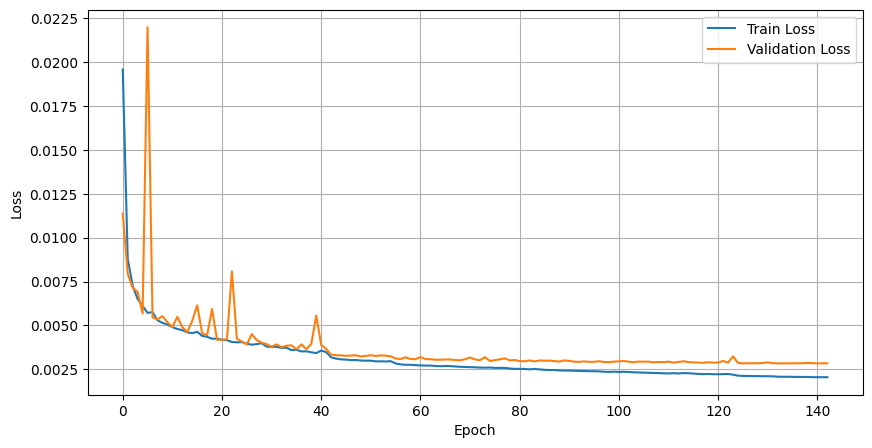

In [22]:
# TRAINING
if __name__ == "__main__":
    try:
        model = BaseAutoencoder(latent_dim=256)
        config = TrainingConfig(
            learning_rate=1e-4,
            batch_size=64,  # Increased batch size
            accumulation_steps=1,  # Gradient accumulation
            epochs=300,
            use_mixed_precision=True,
            num_workers=8,
            prefetch_factor=6,
            pin_memory=True
        )

        train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, config)

    except Exception as e:
        print(f"Error during training: {str(e)}")
        import traceback
        traceback.print_exc()

### Evaluation and Result Visualization

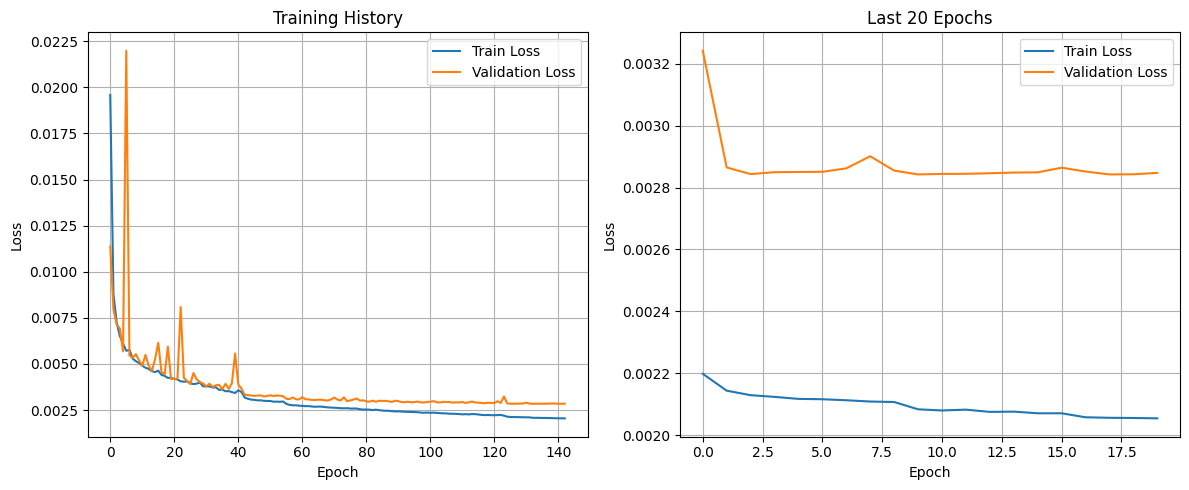

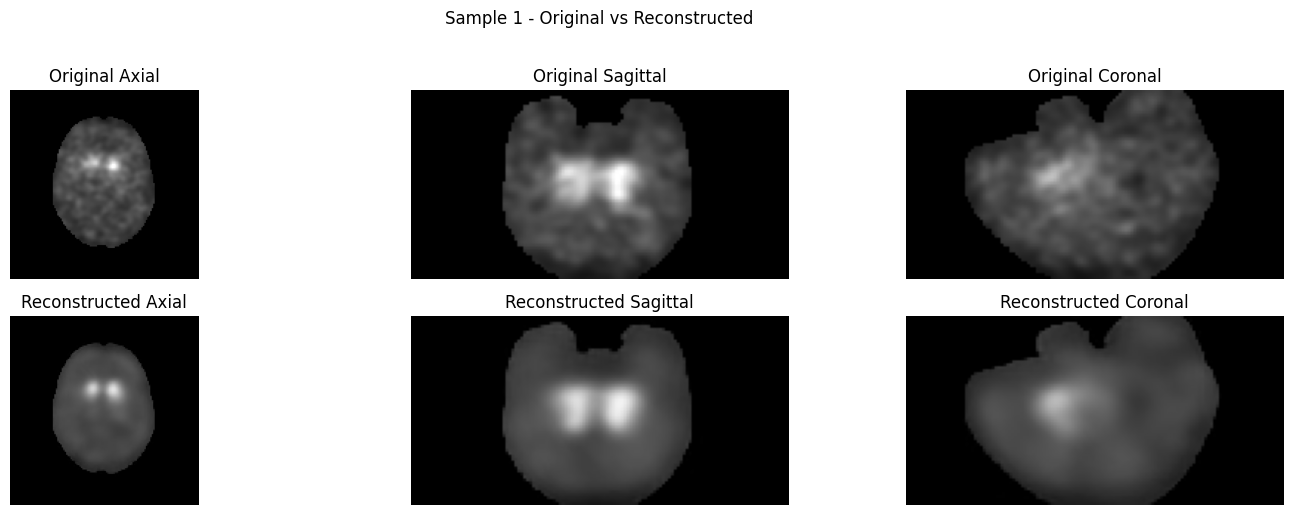

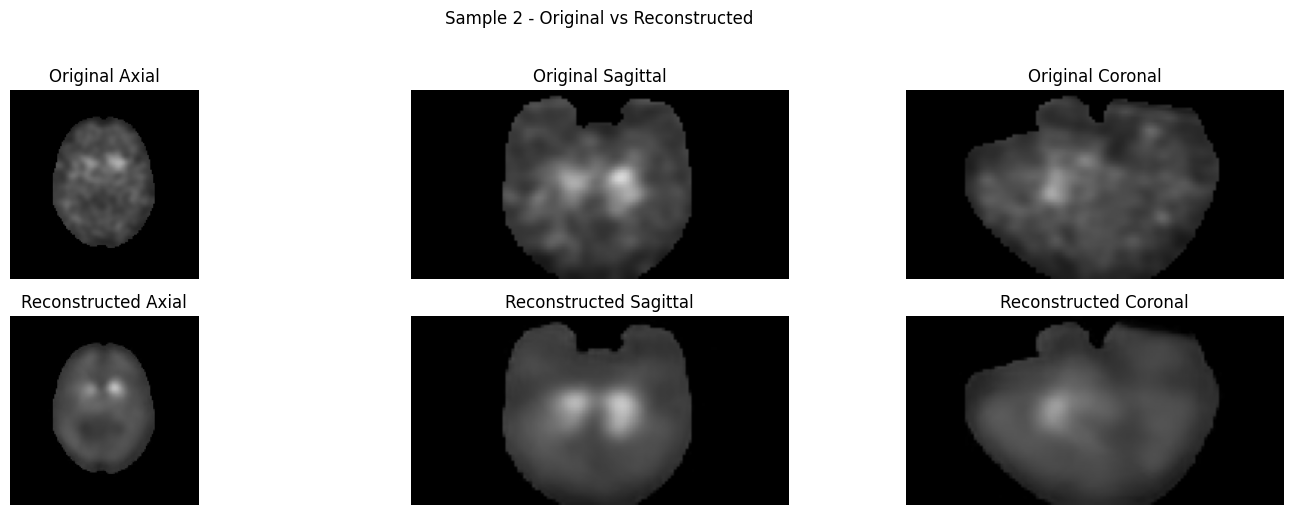

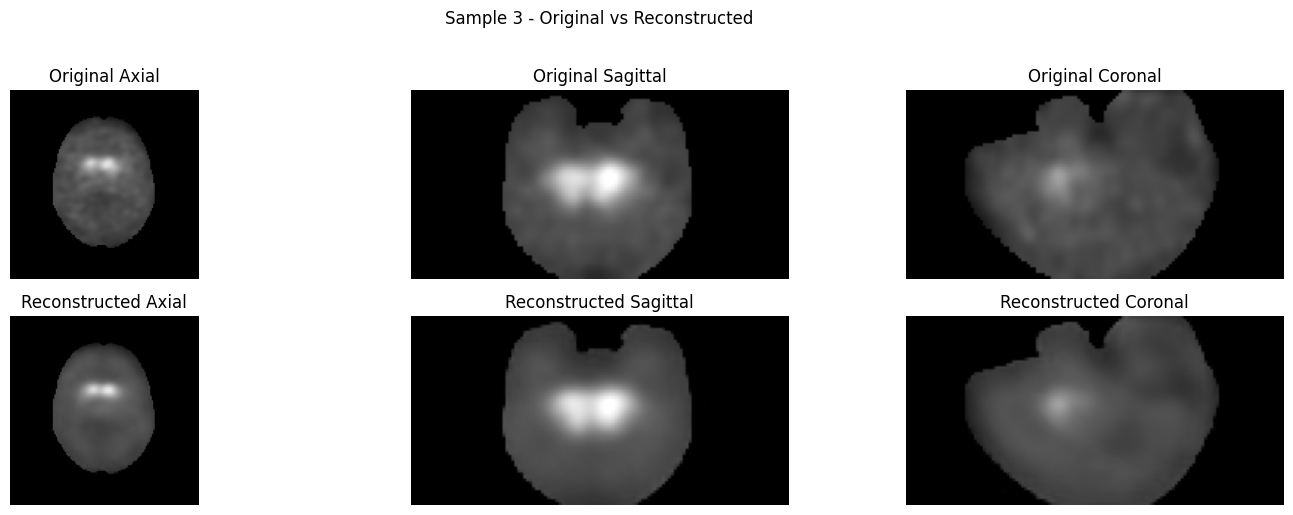

Computing metrics:   0%|          | 0/38 [00:00<?, ?it/s]


Validation Metrics:
Average MSE: 0.002840
RMSE: 0.053288


In [23]:
# Cell 14: Model Evaluation and Visualization
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from pathlib import Path

def load_checkpoint_for_evaluation(checkpoint_dir, model_name):
    """Load model and training history for evaluation"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Load model
    model = BaseAutoencoder()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, metadata

def plot_training_history(metadata):
    """Plot training and validation losses"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metadata['train_losses'], label='Train Loss')
    plt.plot(metadata['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)

    # Plot recent epochs in detail
    recent_epochs = 20
    if len(metadata['train_losses']) > recent_epochs:
        plt.subplot(1, 2, 2)
        plt.plot(metadata['train_losses'][-recent_epochs:], label='Train Loss')
        plt.plot(metadata['val_losses'][-recent_epochs:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Last {recent_epochs} Epochs')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes"""
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 5))

                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_vol = reconstructed[idx, 0].cpu().numpy()

                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[34, :, :],
                    orig_vol[:, 50, :],
                    orig_vol[:, :, 75]
                ]
                slices_recon = [
                    recon_vol[34, :, :],
                    recon_vol[:,50, :],
                    recon_vol[:, :, 75]
                ]

                for i, (view, orig_slice, recon_slice) in enumerate(zip(views, slices_orig, slices_recon)):
                    # Original
                    plt.subplot(2, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Original {view}')
                    plt.axis('off')

                    # Reconstructed
                    plt.subplot(2, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')

                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed', y=1.02)
                plt.tight_layout()
                plt.show()

            break  # Only process first batch

def compute_metrics(model, val_loader):
    """Compute quantitative metrics on validation set"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss()

    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            mse = mse_criterion(reconstructed, volumes).item()
            total_mse += mse * volumes.shape[0]
            total_samples += volumes.shape[0]

    avg_mse = total_mse / total_samples
    print(f"\nValidation Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

# Example usage
if __name__ == "__main__":
    # Load latest checkpoint
    model, metadata = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Plot training history
    plot_training_history(metadata)

    # Visualize reconstructions
    visualize_reconstructions(model, val_loader)

    # Compute metrics
    compute_metrics(model, val_loader)

1. latent 512: MSE val 0.006006; RMSE: 0.0775
2. latent 256: MSE val 0.0067
3. latent 128: MSE val 0.0087

1. masked latent 128: 0.004508
2. masked latent 256: 0.004092

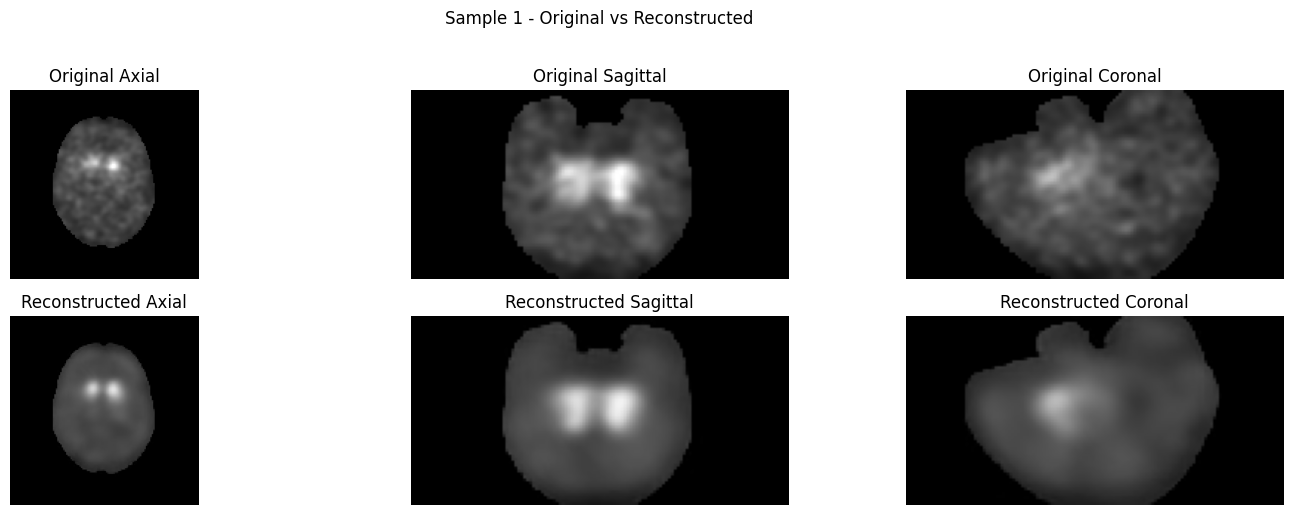

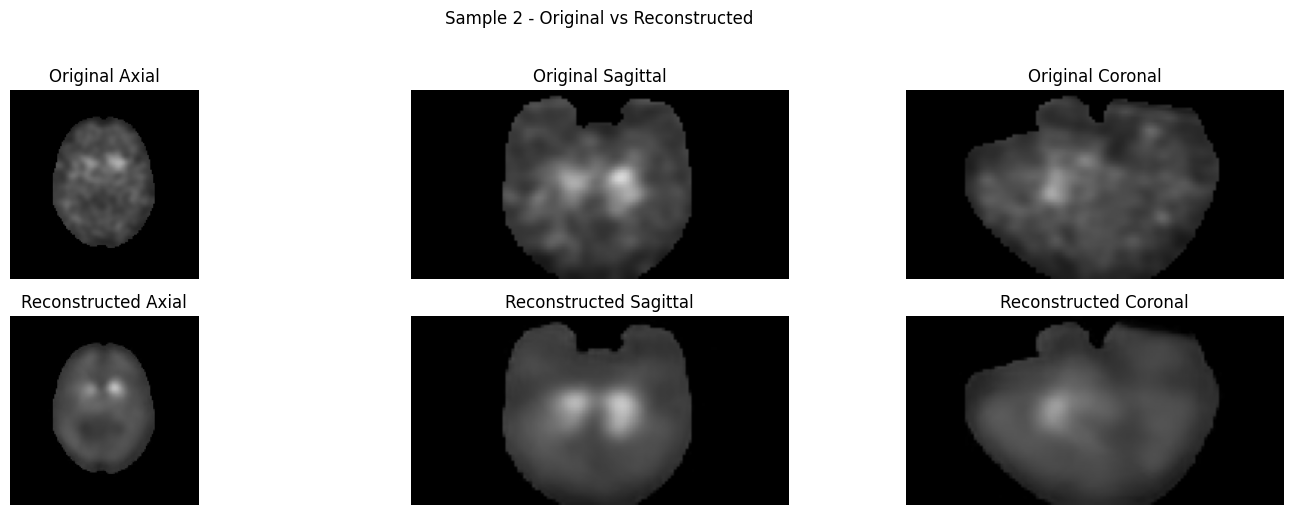

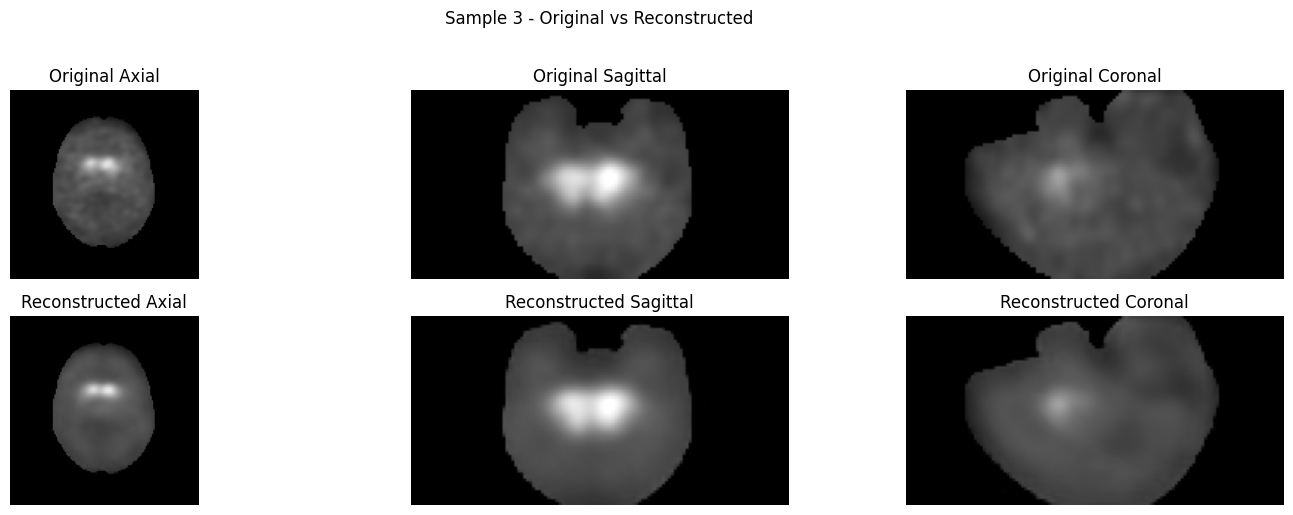

In [27]:
visualize_reconstructions(model, val_loader)

### Find outliers

In [28]:
import torch.nn.functional as F
reconstruction_errors = {}
with torch.no_grad():
    for b in tqdm(train_loader):
        m = b['volume'].to(device)
        o = model(m)
        l = F.mse_loss(o, m, reduction='none')
        l = l.view(l.size(0), -1).mean(dim=1)       
        for label, error in zip(b['path'], l):
                reconstruction_errors[label] = error.item()    

  0%|          | 0/149 [00:00<?, ?it/s]

In [29]:
reconstruction_val = {}
with torch.no_grad():
    for b in tqdm(val_loader):
        m = b['volume'].to(device)
        o = model(m)
        l = F.mse_loss(o, m, reduction='none')
        l = l.view(l.size(0), -1).mean(dim=1)       
        for label, error in zip(b['path'], l):
                reconstruction_val[label] = error.item()    

  0%|          | 0/38 [00:00<?, ?it/s]

(0.0, 10.0)

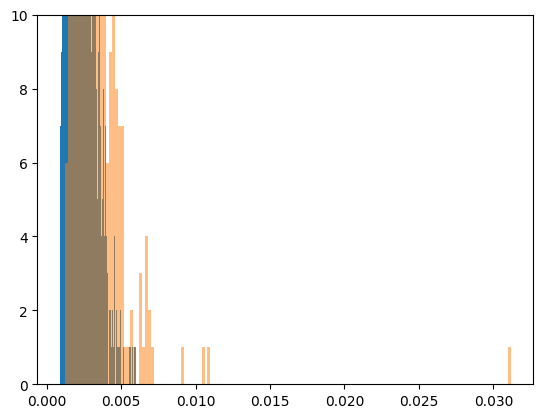

In [33]:
#_=plt.hist(reconstruction_errors.values(),1000)
plt.rcdefaults()
_=plt.hist(reconstruction_errors.values(),100)
_=plt.hist(reconstruction_val.values(),150,alpha=0.5)
plt.ylim(0,10)

In [34]:
badPT = {label: error for label, error in reconstruction_val.items() if error>.009}

In [ ]:
err*1e4

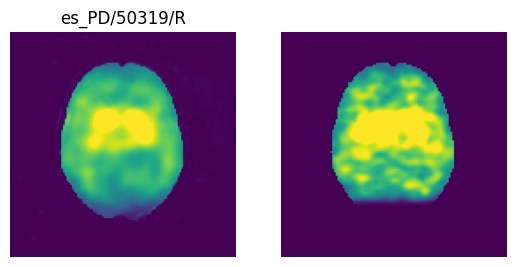

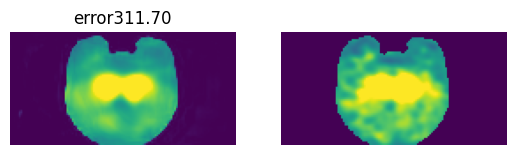

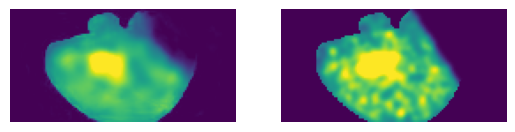

press any key 


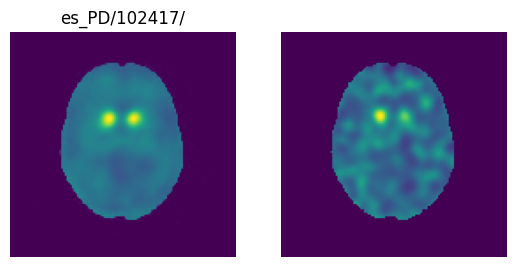

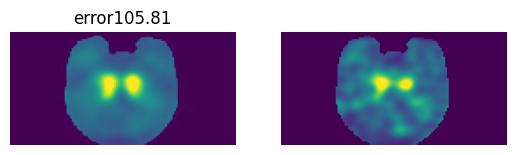

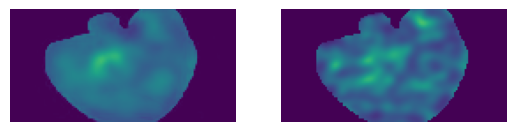

press any key 


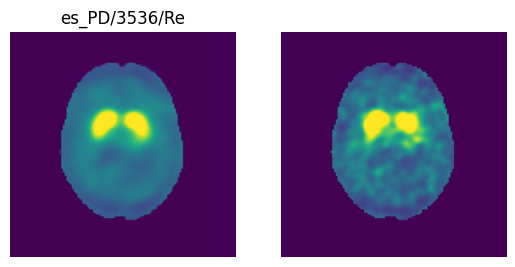

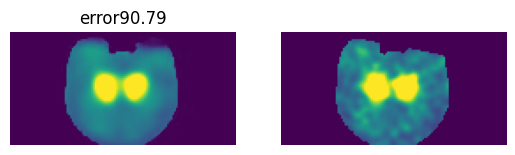

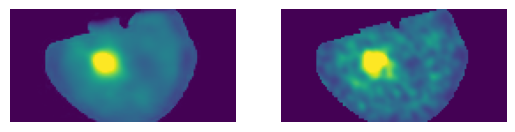

press any key 


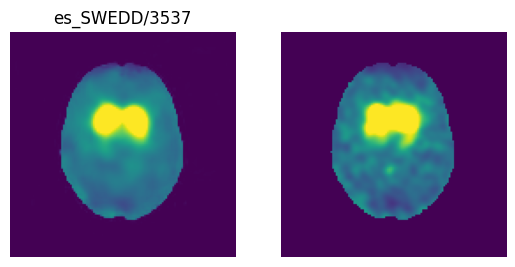

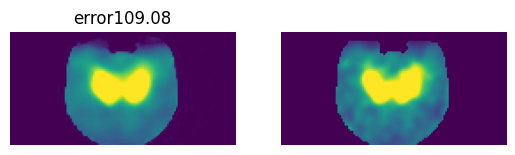

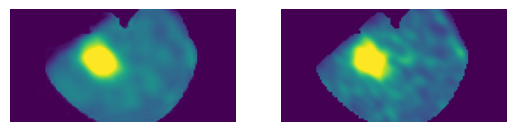

press any key 


In [35]:
maskH = nib.load('rmask_ICV.nii')
maskM = maskH.get_fdata()>0.5
maskM = np.transpose(maskM,[2, 1, 0])
maskM = np.flip(maskM,axis=1)  
with torch.no_grad():
    for path, err in badPT.items(): #badPT.items()
        original_volume, _ = load_dicom(path)
        original_volume *= maskM
        original_volume = original_volume[9:73,:,:]
        norm_vol, _, _ = process_volume(original_volume, target_shape=(64,128,128))
        inpT =  torch.from_numpy(np.expand_dims(norm_vol,axis=(0,1))).float()
        inpT = inpT.to(device)
       # model.to(device)
        o = model(inpT)
        o = o.to('cpu')
        plt.figure()
        plt.subplot(121)
        plt.imshow(o[0,0,33,:,:],vmin=0,vmax=3)
        plt.title(path[22:35])
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(norm_vol[33,:,:],vmin=0,vmax=3)
        plt.axis('off')
        plt.figure()
        plt.subplot(121)
        plt.imshow(o[0,0,:,50,:],vmin=0,vmax=3)
        plt.title(f'error{err*1e4:.2f}')
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(norm_vol[:,50,:],vmin=0,vmax=3)
        plt.axis('off') 
        plt.figure()
        plt.subplot(121)
        plt.imshow(o[0,0,:,:,75],vmin=0,vmax=3)
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(norm_vol[:,:,75],vmin=0,vmax=3)
        plt.axis('off')        
        plt.show()
        input("press any key")
        
        plt.close()
        

In [ ]:

plt.imshow(norm_vol[32,:,:])
plt.colorbar()

In [ ]:
for b in train_loader:
    for iIdx in range(15):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(b['volume'][iIdx,0,32,:,:],vmin=0,vmax=1)
        plt.subplot(1,3,2)
        plt.imshow(b['volume'][iIdx,0,:,70,:],vmin=0,vmax=1)
        plt.subplot(1,3,3)
        plt.imshow(b['volume'][iIdx,0,:,:,64],vmin=0,vmax=1)
        

### Latent Space Analysis

Extracting latent representations:   0%|          | 0/38 [00:00<?, ?it/s]

Generating t-SNE visualization...


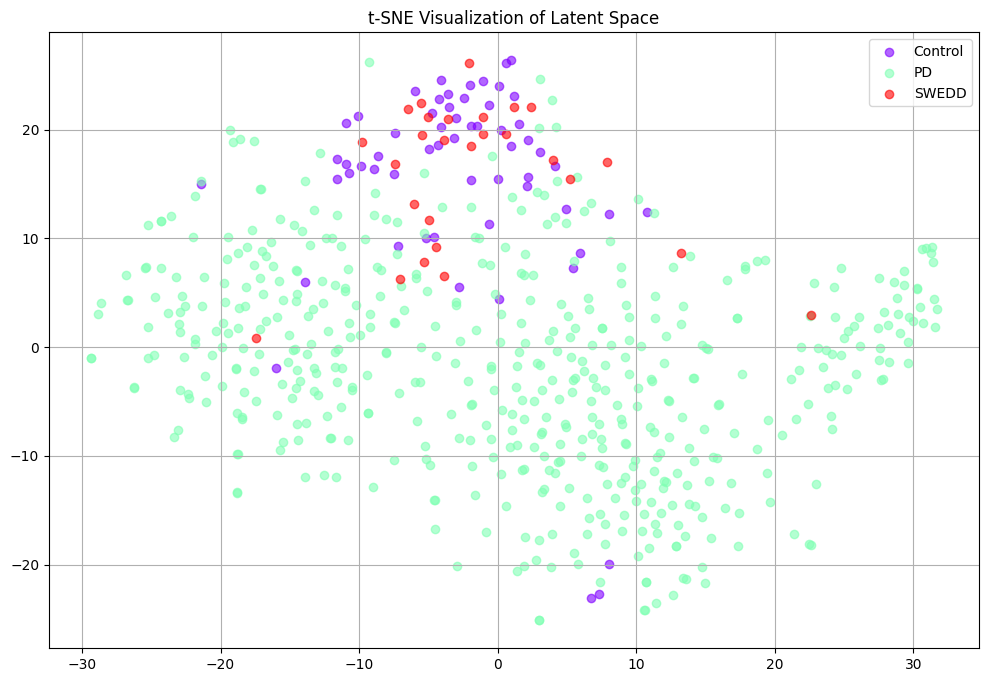


Generating PCA visualization...


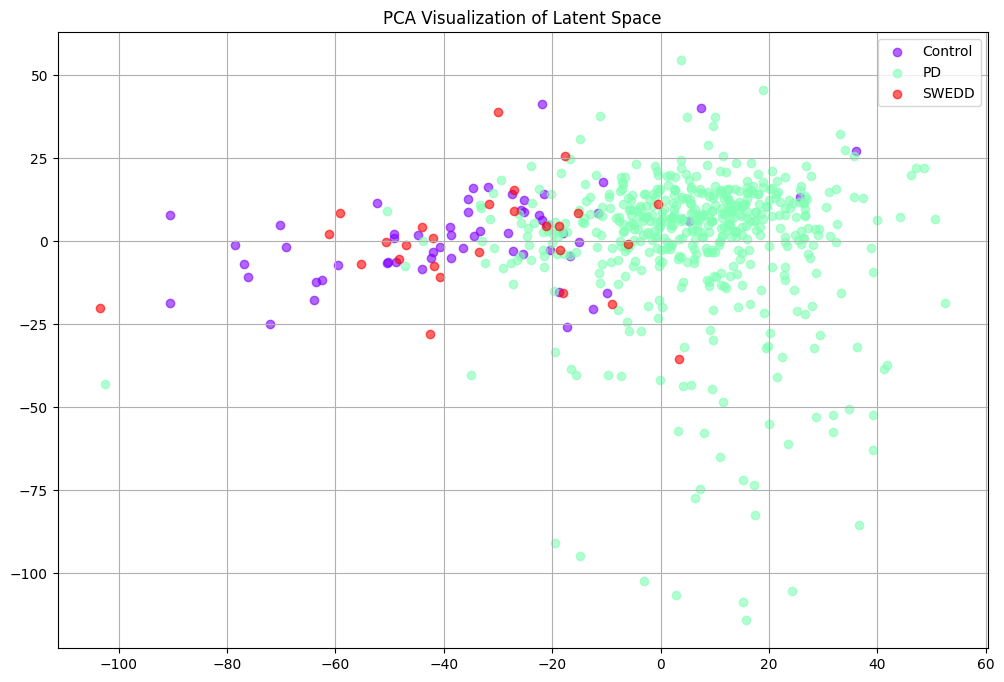


Analyzing latent dimensions...


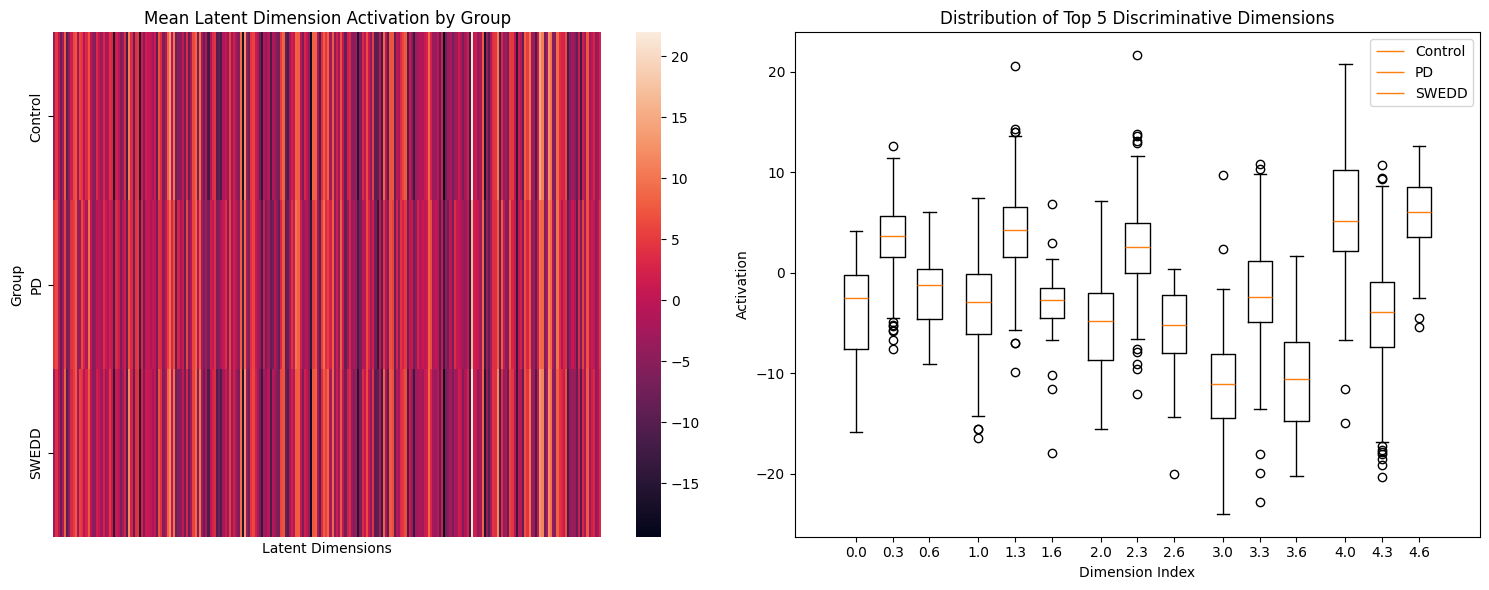

In [36]:
# Cell 15: Latent Space Analysis
import torch
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_latent_representations(model, dataloader, device):
    """
    Extract latent representations and corresponding labels for all samples
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent representations"):
            volumes = batch['volume'].to(device)
            # Get latent vectors using the encode method
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            # Clean up memory
            del volumes, z
            torch.cuda.empty_cache()

    return np.vstack(latent_vectors), np.array(labels)

def visualize_latent_space(latent_vectors, labels, method='tsne'):
    """
    Visualize latent space using t-SNE or PCA
    """
    plt.figure(figsize=(12, 8))

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = 't-SNE Visualization of Latent Space'
    else:
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Space'

    # Reduce dimensionality
    reduced_vecs = reducer.fit_transform(latent_vectors)

    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(reduced_vecs[mask, 0], reduced_vecs[mask, 1],
                   label=label, color=color, alpha=0.6)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return reduced_vecs

def analyze_latent_dimensions(latent_vectors, labels):
    """
    Analyze the distribution of values in each latent dimension
    """
    plt.figure(figsize=(15, 6))

    # Plot distribution of latent values per group
    unique_labels = np.unique(labels)

    # Compute mean activation per dimension for each group
    mean_activations = defaultdict(list)
    for label in unique_labels:
        mask = labels == label
        mean_activations[label] = np.mean(latent_vectors[mask], axis=0)

    # Plot heatmap of mean activations
    activation_matrix = np.vstack([mean_activations[label] for label in unique_labels])
    plt.subplot(1, 2, 1)
    sns.heatmap(activation_matrix, xticklabels=False, yticklabels=unique_labels)
    plt.title('Mean Latent Dimension Activation by Group')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Group')

    # Plot top discriminative dimensions
    variance_ratio = np.var(activation_matrix, axis=0)
    top_dims = np.argsort(variance_ratio)[-5:]  # Top 5 dimensions

    plt.subplot(1, 2, 2)
    for label in unique_labels:
        mask = labels == label
        plt.boxplot([latent_vectors[mask, dim] for dim in top_dims],
                   positions=np.arange(len(top_dims)) + (unique_labels == label).nonzero()[0][0] * 0.3,
                   widths=0.2, label=label)

    plt.title('Distribution of Top 5 Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    # Load model and move to device
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Extract latent representations
    latent_vecs, labels = extract_latent_representations(model, val_loader, device)

    # Visualize using t-SNE and PCA
    print("Generating t-SNE visualization...")
    tsne_coords = visualize_latent_space(latent_vecs, labels, method='tsne')

    print("\nGenerating PCA visualization...")
    pca_coords = visualize_latent_space(latent_vecs, labels, method='pca')

    # Analyze latent dimensions
    print("\nAnalyzing latent dimensions...")
    analyze_latent_dimensions(latent_vecs, labels)

In [ ]:
# Cell 16: Region-based Reconstruction Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def analyze_reconstruction_quality_by_region(model, dataloader, device):
    """
    Analyze reconstruction quality in different brain regions
    """
    model.eval()
    region_errors = defaultdict(list)

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing reconstruction quality"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            # Calculate error for each region
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon = reconstructed[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

            # Clean up
            del volumes, reconstructed
            torch.cuda.empty_cache()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.boxplot([region_errors[region] for region in regions.keys()],
                labels=regions.keys())
    plt.title('Reconstruction Error by Brain Region')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print("\nReconstruction Error Statistics by Region:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing reconstruction quality by region...")
    analyze_reconstruction_quality_by_region(model, val_loader, device)

Analyzing latent space clinical correlations...


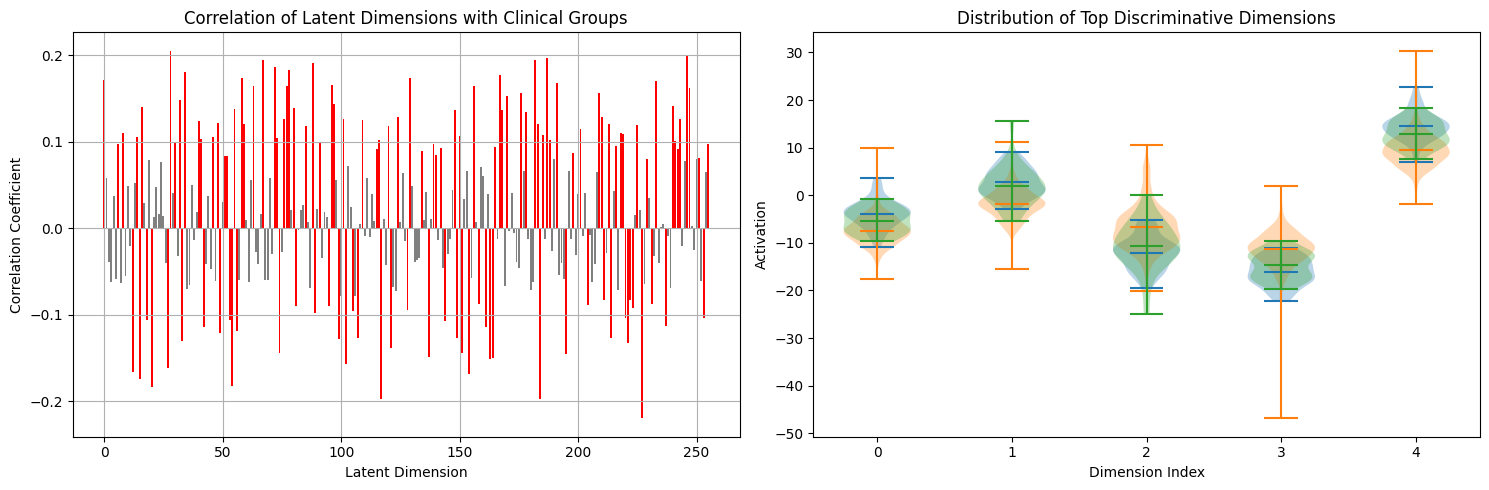


Top 5 Most Discriminative Dimensions:

Dimension 184:
Correlation: -0.197
P-value: 1.204e-06

Dimension 117:
Correlation: -0.198
P-value: 1.120e-06

Dimension 246:
Correlation: 0.200
P-value: 8.618e-07

Dimension 28:
Correlation: 0.205
P-value: 4.486e-07

Dimension 227:
Correlation: -0.220
P-value: 6.045e-08


In [37]:
# Cell 17: Latent Space Clinical Correlation
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_latent_clinical_correlation(latent_vectors, labels):
    """
    Analyze correlation between latent dimensions and clinical groups
    """
    # Convert labels to numeric for correlation analysis
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    numeric_labels = np.array([label_mapping[label] for label in labels])

    # Calculate correlation between each latent dimension and the clinical groups
    correlations = []
    p_values = []

    for dim_idx in range(latent_vectors.shape[1]):
        corr, p_val = spearmanr(latent_vectors[:, dim_idx], numeric_labels)
        correlations.append(corr)
        p_values.append(p_val)

    # Plot correlation heatmap
    plt.figure(figsize=(15, 5))

    # Plot correlations
    plt.subplot(1, 2, 1)
    significant_dims = np.array(p_values) < 0.05
    plt.bar(range(len(correlations)), correlations,
            color=['red' if sig else 'gray' for sig in significant_dims])
    plt.title('Correlation of Latent Dimensions with Clinical Groups')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)

    # Plot most discriminative dimensions
    top_dims = np.argsort(np.abs(correlations))[-5:]
    plt.subplot(1, 2, 2)
    for label in np.unique(labels):
        mask = labels == label
        values = latent_vectors[mask][:, top_dims]
        plt.violinplot(values, positions=range(len(top_dims)),
                      showmeans=True, showextrema=True)

    plt.title('Distribution of Top Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.tight_layout()
    plt.show()

    # Print summary of most significant dimensions
    print("\nTop 5 Most Discriminative Dimensions:")
    for dim_idx in top_dims:
        print(f"\nDimension {dim_idx}:")
        print(f"Correlation: {correlations[dim_idx]:.3f}")
        print(f"P-value: {p_values[dim_idx]:.3e}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing latent space clinical correlations...")
    analyze_latent_clinical_correlation(latent_vecs, labels)

### Synthetic Brain Generation

In [ ]:
# Cell 18: Synthetic Brain Generation
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_synthetic_brain(model, dataloader, condition='PD', num_samples=5):
    """
    Generate synthetic brain scans by manipulating the latent space

    Args:
        model: Trained autoencoder model
        dataloader: DataLoader containing the validation set
        condition: Target condition ('PD', 'Control', or 'SWEDD')
        num_samples: Number of synthetic samples to generate
    """
    device = next(model.parameters()).device
    model.eval()

    # First, get latent representations of real brains
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            # Get latent vectors
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Calculate mean and covariance of latent vectors for target condition
    target_mask = conditions == condition
    target_vectors = latent_vectors[target_mask]
    latent_mean = np.mean(target_vectors, axis=0)
    latent_cov = np.cov(target_vectors.T)

    # Generate new latent vectors by sampling from learned distribution
    print(f"\nGenerating synthetic {condition} brains...")
    synthetic_vectors = np.random.multivariate_normal(
        latent_mean,
        latent_cov + 1e-6 * np.eye(latent_cov.shape[0]),  # Add small value to ensure positive definiteness
        size=num_samples
    )

    # Convert to torch tensor and move to device
    synthetic_vectors = torch.tensor(synthetic_vectors, dtype=torch.float32).to(device)

    # Generate synthetic brains using decoder
    with torch.no_grad():
        synthetic_brains = model.decode(synthetic_vectors)

    # Visualize results
    fig = plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        brain = synthetic_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Synthetic {condition} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Synthetic {condition} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Synthetic {condition} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return synthetic_brains

def interpolate_between_conditions(model, dataloader, start_condition='Control', end_condition='PD', steps=5):
    """
    Generate interpolated brains between two conditions
    """
    device = next(model.parameters()).device
    model.eval()

    # Get latent representations
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Get mean latent vectors for both conditions
    start_mean = np.mean(latent_vectors[conditions == start_condition], axis=0)
    end_mean = np.mean(latent_vectors[conditions == end_condition], axis=0)

    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    interpolated_vectors = np.array([
        (1 - alpha) * start_mean + alpha * end_mean
        for alpha in alphas
    ])

    # Generate interpolated brains
    interpolated_vectors = torch.tensor(interpolated_vectors, dtype=torch.float32).to(device)

    with torch.no_grad():
        interpolated_brains = model.decode(interpolated_vectors)

    # Visualize interpolation
    fig = plt.figure(figsize=(15, 3*steps))

    for i in range(steps):
        brain = interpolated_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(steps, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.suptitle(f'Interpolation from {start_condition} to {end_condition}')
    plt.tight_layout()
    plt.show()

    return interpolated_brains

# Run the generation
if __name__ == "__main__":
    # Load model
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Generate synthetic brains for each condition
    print("\nGenerating synthetic Control brains...")
    synthetic_control = generate_synthetic_brain(model, val_loader, condition='Control')

    print("\nGenerating synthetic PD brains...")
    synthetic_pd = generate_synthetic_brain(model, val_loader, condition='PD')

    print("\nGenerating synthetic SWEDD brains...")
    synthetic_swedd = generate_synthetic_brain(model, val_loader, condition='SWEDD')

    # Generate interpolation between conditions
    print("\nGenerating interpolation from Control to PD...")
    interpolated = interpolate_between_conditions(model, val_loader)

## 2. Variational Autoencoder (VAE)

### Model Setup

In [31]:
# Cell 19: VAE Model Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class VAE(nn.Module):
    """
    3D Variational Autoencoder optimized for 128³ medical volumes with
    memory-efficient implementation for NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        # Enable CUDNN benchmarking for optimal performance
        torch.backends.cudnn.benchmark = True

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to enable backpropagation through sampling.
        """
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        # Encode input to get mean and variance of latent distribution
        mu, log_var = self.encoder(x)

        # Sample from latent distribution
        z = self.reparameterize(mu, log_var)

        # Decode sampled latent vector
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class VAEEncoder(nn.Module):
    """3D Encoder network with probabilistic latent space."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 128 -> 128

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # 128 -> 64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # 64 -> 32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # 32 -> 16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # 16 -> 8
            ConvBlock(256, 256)
        )

        # Project to latent parameters
        self.flatten_size = 256 * 8 * 8 * 4
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Initial convolution
        x = self.init_conv(x)

        # Downsampling with skip connections
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent parameters
        flat = torch.flatten(d4, start_dim=1)
        mu = self.fc_mu(flat)
        log_var = self.fc_var(flat)

        return mu, log_var #, (d1, d2, d3, d4)

class VAEDecoder(nn.Module):
    """3D Decoder network with skip connections."""
    def __init__(self, latent_dim=256):
        super().__init__()

        
        self.flatten_size = 256 * 8 * 8 * 4
        self.fc = nn.Linear(latent_dim, self.flatten_size)
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(256,128),
          #  nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2),  # 8 -> 16
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            #nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2),   # 16 -> 32
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(128,64),
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
           # nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),    # 32 -> 64
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(64,32),
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            #nn.ConvTranspose3d(16, 16, kernel_size=2, stride=2),    # 64 -> 128
            nn.Upsample(scale_factor=2,mode='trilinear'),
            ConvBlock(32,16),
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)        

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)

        # Final convolution with sigmoid activation
        x = self.final_conv(x)

        return x

In [32]:
# Cell 20: VAE Loss Function Implementation
class VAELoss:
    """
    Custom loss function for VAE combining reconstruction loss and KL divergence.
    Implements β-VAE formulation with annealing for better training stability.
    """
    def __init__(self, beta_start=0.0, beta_end=1.0, beta_steps=10000):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_steps = beta_steps
        self.current_step = 0

    def __call__(self, recon_x, x, mu, log_var):
        """
        Compute VAE loss with annealed β-VAE formulation.

        Args:
            recon_x: Reconstructed volume
            x: Original volume
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')

        # KL divergence
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        # Calculate beta for current step
        beta = min(self.beta_end,
                  self.beta_start + (self.beta_end - self.beta_start) *
                  (self.current_step / self.beta_steps))

        # Increment step
        self.current_step += 1

        # Total loss
        total_loss = recon_loss + beta * kl_loss

        return total_loss, recon_loss, kl_loss, beta

### Config

In [177]:
# Cell 21: Training Configuration and Utilities
from tqdm.notebook import tqdm
import os
from pathlib import Path
import json
import time

class VAEConfig:
    """Configuration for VAE training."""
    def __init__(self):
        # Model parameters
        self.latent_dim = 256
        self.learning_rate = 1e-4

        # Training parameters
        self.batch_size = 8  # Conservative batch size for 12GB VRAM
        self.epochs = 300
        self.accumulation_steps =  2 # Gradient accumulation for effective batch size of 32

        # Loss parameters
        self.beta_start = 3e-3
        self.beta_end = 3e-1
        self.beta_steps = 1000

        # Early stopping
        self.patience = 20
        self.min_delta = 1e-6

        # Optimization
        self.use_amp = True  # Automatic mixed precision
        self.num_workers = 4
        self.pin_memory = True

        # Checkpoint configuration
        self.checkpoint_dir = 'checkpoints'
        self.model_name = 'vae_Beta3e1'
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses):
        """Save model checkpoint and training metadata"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        torch.save(checkpoint, self.checkpoint_path)

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer, scheduler):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            return None

        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint['scheduler_state_dict']:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }


In [178]:
# Cell 22: Training Loop
def train_vae(model, train_loader, val_loader, config=None):
    """Training loop with memory optimization for 4070Ti."""
    if config is None:
        config = VAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = VAELoss(config.beta_start, config.beta_end, config.beta_steps)
    optimizer = create_vae_optimizer(model, config)
    scheduler = create_vae_scheduler(optimizer)
    scaler = torch.cuda.amp.GradScaler(enabled=config.use_amp)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_recon_loss = 0
            train_kl_loss = 0

            train_pbar = tqdm(train_loader,
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False)

            for i, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)

                    # Forward pass with mixed precision
                    with torch.cuda.amp.autocast(enabled=config.use_amp):
                        recon, mu, log_var = model(volumes)
                        loss, recon_l, kl_l, beta = criterion(recon, volumes, mu, log_var)
                        loss = loss / config.accumulation_steps

                    # Backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (i + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track losses
                    train_loss += loss.item() * config.accumulation_steps
                    train_recon_loss += recon_l.item()
                    train_kl_loss += kl_l.item()

                    # Update progress bar
                    train_pbar.set_postfix({
                        'loss': loss.item() * config.accumulation_steps,
                        'recon': recon_l.item(),
                        'kl': kl_l.item(),
                        'beta': beta
                    })

                    # Clean up
                    del volumes, recon, mu, log_var
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {i}. Cleaning up...")
                        if 'volumes' in locals():
                            del volumes
                        if 'recon' in locals():
                            del recon
                        torch.cuda.empty_cache()
                        continue
                    raise e

            # Validation phase
            model.eval()
            val_loss = 0

            val_pbar = tqdm(val_loader,
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        recon, mu, log_var = model(volumes)
                        loss, _, _, _ = criterion(recon, volumes, mu, log_var)
                        val_loss += loss.item()

                        val_pbar.set_postfix({'loss': loss.item()})

                        del volumes, recon, mu, log_var
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'recon' in locals():
                                del recon
                            torch.cuda.empty_cache()
                            continue
                        raise e

            # Calculate average losses
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )

            # Early stopping check
            if avg_val_loss < best_val_loss - config.min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(),
                         os.path.join(config.checkpoint_dir, f'{config.model_name}_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

            # Print epoch summary
            print(f"\nEpoch [{epoch+1}/{config.epochs}]")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print(f"Beta: {beta:.4f}")
            print_gpu_memory_stats()  # From previous implementation

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

    return train_losses, val_losses

def create_vae_optimizer(model, config):
    """Create optimizer for VAE training."""
    return torch.optim.Adam(model.parameters(), lr=config.learning_rate)

def create_vae_scheduler(optimizer):
    """Create learning rate scheduler for VAE training."""
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

### Training

Epoch 1/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 1/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [1/300]
Train Loss: 0.048457
Val Loss: 0.022107
Beta: 0.0470
GPU Memory Allocated: 1341.37 MB
GPU Memory Reserved: 6968.00 MB


Epoch 2/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 2/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [2/300]
Train Loss: 0.055564
Val Loss: 0.021304
Beta: 0.1025
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 3/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 3/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [3/300]
Train Loss: 0.055918
Val Loss: 0.028909
Beta: 0.1580
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 4/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 4/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [4/300]
Train Loss: 0.023034
Val Loss: 0.022967
Beta: 0.2136
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 5/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 5/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [5/300]
Train Loss: 0.024128
Val Loss: 0.021880
Beta: 0.2691
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 6/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 6/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [6/300]
Train Loss: 0.025412
Val Loss: 0.019853
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 7/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 7/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [7/300]
Train Loss: 0.022895
Val Loss: 0.028292
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 8/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 8/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [8/300]
Train Loss: 0.023426
Val Loss: 0.019886
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 9/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 9/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [9/300]
Train Loss: 0.019711
Val Loss: 0.018529
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 10/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 10/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [10/300]
Train Loss: 0.019903
Val Loss: 0.044765
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 11/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 11/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [11/300]
Train Loss: 0.022919
Val Loss: 0.015534
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 12/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 12/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [12/300]
Train Loss: 0.018086
Val Loss: 0.014139
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 13/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 13/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [13/300]
Train Loss: 0.017180
Val Loss: 0.013763
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 14/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 14/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [14/300]
Train Loss: 0.016485
Val Loss: 0.014781
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 15/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 15/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [15/300]
Train Loss: 0.016479
Val Loss: 0.015400
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 16/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 16/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [16/300]
Train Loss: 0.015806
Val Loss: 0.012939
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 17/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 17/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [17/300]
Train Loss: 0.015909
Val Loss: 0.013114
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 18/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 18/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [18/300]
Train Loss: 0.015418
Val Loss: 0.012935
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 19/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 19/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [19/300]
Train Loss: 0.014966
Val Loss: 0.014865
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 20/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 20/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [20/300]
Train Loss: 0.014755
Val Loss: 0.014557
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 21/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 21/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [21/300]
Train Loss: 0.014617
Val Loss: 0.013022
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 22/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 22/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [22/300]
Train Loss: 0.014025
Val Loss: 0.012785
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 23/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 23/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [23/300]
Train Loss: 0.013832
Val Loss: 0.011965
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 24/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 24/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [24/300]
Train Loss: 0.013800
Val Loss: 0.012312
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 25/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 25/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [25/300]
Train Loss: 0.013186
Val Loss: 0.011504
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 26/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 26/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [26/300]
Train Loss: 0.013006
Val Loss: 0.011852
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 27/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 27/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [27/300]
Train Loss: 0.012988
Val Loss: 0.012723
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 28/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 28/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [28/300]
Train Loss: 0.012696
Val Loss: 0.011494
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 29/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 29/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [29/300]
Train Loss: 0.012563
Val Loss: 0.012463
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 30/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 30/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [30/300]
Train Loss: 0.012480
Val Loss: 0.010987
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 31/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 31/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [31/300]
Train Loss: 0.012151
Val Loss: 0.012404
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 32/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 32/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [32/300]
Train Loss: 0.012103
Val Loss: 0.011321
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 33/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 33/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [33/300]
Train Loss: 0.012041
Val Loss: 0.011888
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 34/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 34/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [34/300]
Train Loss: 0.011877
Val Loss: 0.011203
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 35/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 35/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [35/300]
Train Loss: 0.011649
Val Loss: 0.010835
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 36/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 36/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [36/300]
Train Loss: 0.011558
Val Loss: 0.010838
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 37/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 37/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [37/300]
Train Loss: 0.011514
Val Loss: 0.010792
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 38/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 38/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [38/300]
Train Loss: 0.011346
Val Loss: 0.010500
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 39/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 39/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [39/300]
Train Loss: 0.011168
Val Loss: 0.010700
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 40/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 40/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [40/300]
Train Loss: 0.011079
Val Loss: 0.010540
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 41/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 41/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [41/300]
Train Loss: 0.011009
Val Loss: 0.010735
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 42/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 42/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [42/300]
Train Loss: 0.010893
Val Loss: 0.010436
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 43/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 43/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [43/300]
Train Loss: 0.010861
Val Loss: 0.010917
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 44/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 44/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [44/300]
Train Loss: 0.010768
Val Loss: 0.010645
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 45/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 45/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [45/300]
Train Loss: 0.010742
Val Loss: 0.010328
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 46/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 46/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [46/300]
Train Loss: 0.010641
Val Loss: 0.010234
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 47/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 47/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [47/300]
Train Loss: 0.010634
Val Loss: 0.010644
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 48/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 48/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [48/300]
Train Loss: 0.010667
Val Loss: 0.010268
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 49/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 49/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [49/300]
Train Loss: 0.010726
Val Loss: 0.010031
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 50/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 50/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [50/300]
Train Loss: 0.010520
Val Loss: 0.010269
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 51/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 51/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [51/300]
Train Loss: 0.010455
Val Loss: 0.010286
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 52/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 52/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [52/300]
Train Loss: 0.010329
Val Loss: 0.009874
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 53/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 53/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [53/300]
Train Loss: 0.010310
Val Loss: 0.010015
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 54/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 54/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [54/300]
Train Loss: 0.010354
Val Loss: 0.010049
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 55/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 55/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [55/300]
Train Loss: 0.010238
Val Loss: 0.009774
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 56/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 56/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [56/300]
Train Loss: 0.010165
Val Loss: 0.009591
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 57/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 57/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [57/300]
Train Loss: 0.010231
Val Loss: 0.010012
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 58/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 58/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [58/300]
Train Loss: 0.010338
Val Loss: 0.010034
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 59/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 59/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [59/300]
Train Loss: 0.010245
Val Loss: 0.009629
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 60/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 60/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [60/300]
Train Loss: 0.010073
Val Loss: 0.009540
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 61/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 61/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [61/300]
Train Loss: 0.010060
Val Loss: 0.010038
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 62/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 62/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [62/300]
Train Loss: 0.010118
Val Loss: 0.009592
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 63/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 63/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [63/300]
Train Loss: 0.010112
Val Loss: 0.009452
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 64/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 64/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [64/300]
Train Loss: 0.010082
Val Loss: 0.009399
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 65/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 65/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [65/300]
Train Loss: 0.010240
Val Loss: 0.009808
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 66/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 66/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [66/300]
Train Loss: 0.009969
Val Loss: 0.009631
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 67/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 67/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [67/300]
Train Loss: 0.009964
Val Loss: 0.009558
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 68/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 68/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [68/300]
Train Loss: 0.010096
Val Loss: 0.009539
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 69/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 69/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [69/300]
Train Loss: 0.010029
Val Loss: 0.009781
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 70/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 70/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [70/300]
Train Loss: 0.009919
Val Loss: 0.009358
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 71/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 71/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [71/300]
Train Loss: 0.010155
Val Loss: 0.009497
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 72/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 72/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [72/300]
Train Loss: 0.009955
Val Loss: 0.009519
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 73/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 73/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [73/300]
Train Loss: 0.009930
Val Loss: 0.009467
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 74/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 74/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [74/300]
Train Loss: 0.009826
Val Loss: 0.009048
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 75/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 75/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [75/300]
Train Loss: 0.012143
Val Loss: 0.009649
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 76/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 76/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [76/300]
Train Loss: 0.009911
Val Loss: 0.009053
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 77/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 77/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [77/300]
Train Loss: 0.009830
Val Loss: 0.009201
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 78/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 78/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [78/300]
Train Loss: 0.009803
Val Loss: 0.009196
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 79/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 79/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [79/300]
Train Loss: 0.009785
Val Loss: 0.009157
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 80/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 80/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [80/300]
Train Loss: 0.009715
Val Loss: 0.009145
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 81/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 81/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [81/300]
Train Loss: 0.009522
Val Loss: 0.008965
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 82/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 82/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [82/300]
Train Loss: 0.009492
Val Loss: 0.008871
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 83/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 83/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [83/300]
Train Loss: 0.009487
Val Loss: 0.008860
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 84/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 84/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [84/300]
Train Loss: 0.009422
Val Loss: 0.008732
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 85/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 85/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [85/300]
Train Loss: 0.009432
Val Loss: 0.008796
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 86/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 86/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [86/300]
Train Loss: 0.009356
Val Loss: 0.008724
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 87/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 87/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [87/300]
Train Loss: 0.009379
Val Loss: 0.008845
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 88/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 88/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [88/300]
Train Loss: 0.009451
Val Loss: 0.008773
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 89/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 89/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [89/300]
Train Loss: 0.009317
Val Loss: 0.008742
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 90/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 90/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [90/300]
Train Loss: 0.009385
Val Loss: 0.008770
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 91/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 91/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [91/300]
Train Loss: 0.009357
Val Loss: 0.008889
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 92/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 92/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [92/300]
Train Loss: 0.009339
Val Loss: 0.008663
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 93/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 93/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [93/300]
Train Loss: 0.009360
Val Loss: 0.009035
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 94/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 94/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [94/300]
Train Loss: 0.009409
Val Loss: 0.008878
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 95/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 95/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [95/300]
Train Loss: 0.009350
Val Loss: 0.008676
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 96/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 96/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [96/300]
Train Loss: 0.009427
Val Loss: 0.008712
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 97/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 97/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [97/300]
Train Loss: 0.009337
Val Loss: 0.008803
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 98/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 98/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [98/300]
Train Loss: 0.009377
Val Loss: 0.008861
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 99/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 99/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [99/300]
Train Loss: 0.009230
Val Loss: 0.008638
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 100/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 100/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [100/300]
Train Loss: 0.009166
Val Loss: 0.008703
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 101/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 101/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [101/300]
Train Loss: 0.009164
Val Loss: 0.008576
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 102/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 102/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [102/300]
Train Loss: 0.009166
Val Loss: 0.008563
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 103/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 103/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [103/300]
Train Loss: 0.009157
Val Loss: 0.008628
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 104/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 104/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [104/300]
Train Loss: 0.009108
Val Loss: 0.008505
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 105/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 105/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [105/300]
Train Loss: 0.009129
Val Loss: 0.008549
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 106/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 106/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [106/300]
Train Loss: 0.009111
Val Loss: 0.008413
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 107/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 107/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [107/300]
Train Loss: 0.009203
Val Loss: 0.008541
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 108/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 108/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [108/300]
Train Loss: 0.009163
Val Loss: 0.008629
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 109/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 109/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [109/300]
Train Loss: 0.009092
Val Loss: 0.008529
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 110/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 110/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [110/300]
Train Loss: 0.009161
Val Loss: 0.008424
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 111/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 111/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [111/300]
Train Loss: 0.009085
Val Loss: 0.008479
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 112/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 112/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [112/300]
Train Loss: 0.009076
Val Loss: 0.008674
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 113/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 113/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [113/300]
Train Loss: 0.009097
Val Loss: 0.008444
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 114/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 114/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [114/300]
Train Loss: 0.009073
Val Loss: 0.008560
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 115/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 115/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [115/300]
Train Loss: 0.009077
Val Loss: 0.008443
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 116/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 116/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [116/300]
Train Loss: 0.009069
Val Loss: 0.008465
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 117/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 117/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [117/300]
Train Loss: 0.009012
Val Loss: 0.008347
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 118/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 118/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [118/300]
Train Loss: 0.009037
Val Loss: 0.008461
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 119/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 119/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [119/300]
Train Loss: 0.009030
Val Loss: 0.008354
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 120/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 120/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [120/300]
Train Loss: 0.008998
Val Loss: 0.008412
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 121/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 121/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [121/300]
Train Loss: 0.008987
Val Loss: 0.008388
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 122/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 122/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [122/300]
Train Loss: 0.009085
Val Loss: 0.008482
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 123/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 123/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [123/300]
Train Loss: 0.008993
Val Loss: 0.008556
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 124/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 124/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [124/300]
Train Loss: 0.008949
Val Loss: 0.008412
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 125/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 125/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [125/300]
Train Loss: 0.008969
Val Loss: 0.008387
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 126/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 126/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [126/300]
Train Loss: 0.008955
Val Loss: 0.008437
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 127/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 127/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [127/300]
Train Loss: 0.008973
Val Loss: 0.008395
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 128/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 128/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [128/300]
Train Loss: 0.008951
Val Loss: 0.008417
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 129/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 129/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [129/300]
Train Loss: 0.008873
Val Loss: 0.008473
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 130/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 130/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [130/300]
Train Loss: 0.008884
Val Loss: 0.008385
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 131/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 131/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [131/300]
Train Loss: 0.008930
Val Loss: 0.008390
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 132/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 132/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [132/300]
Train Loss: 0.008953
Val Loss: 0.008419
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 133/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 133/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [133/300]
Train Loss: 0.008909
Val Loss: 0.008468
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 134/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 134/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [134/300]
Train Loss: 0.008995
Val Loss: 0.008417
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 135/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 135/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [135/300]
Train Loss: 0.008958
Val Loss: 0.008317
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 136/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 136/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [136/300]
Train Loss: 0.008921
Val Loss: 0.008360
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 137/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 137/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [137/300]
Train Loss: 0.008931
Val Loss: 0.008396
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 138/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 138/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [138/300]
Train Loss: 0.008958
Val Loss: 0.008426
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 139/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 139/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [139/300]
Train Loss: 0.008912
Val Loss: 0.008399
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 140/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 140/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [140/300]
Train Loss: 0.008946
Val Loss: 0.008400
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 141/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 141/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [141/300]
Train Loss: 0.008887
Val Loss: 0.008453
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 142/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 142/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [142/300]
Train Loss: 0.008929
Val Loss: 0.008395
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 143/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 143/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [143/300]
Train Loss: 0.008887
Val Loss: 0.008399
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 144/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 144/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [144/300]
Train Loss: 0.008866
Val Loss: 0.008415
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 145/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 145/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [145/300]
Train Loss: 0.008873
Val Loss: 0.008362
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 146/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 146/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [146/300]
Train Loss: 0.008998
Val Loss: 0.008393
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 147/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 147/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [147/300]
Train Loss: 0.008922
Val Loss: 0.008405
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 148/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 148/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [148/300]
Train Loss: 0.008941
Val Loss: 0.008390
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 149/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 149/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [149/300]
Train Loss: 0.008823
Val Loss: 0.008394
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 150/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 150/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [150/300]
Train Loss: 0.008921
Val Loss: 0.008368
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 151/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 151/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [151/300]
Train Loss: 0.008870
Val Loss: 0.008330
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4922.00 MB


Epoch 152/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 152/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [152/300]
Train Loss: 0.008908
Val Loss: 0.008358
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 153/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 153/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [153/300]
Train Loss: 0.008884
Val Loss: 0.008399
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 154/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 154/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch [154/300]
Train Loss: 0.008872
Val Loss: 0.008373
Beta: 0.3000
GPU Memory Allocated: 1340.68 MB
GPU Memory Reserved: 4920.00 MB


Epoch 155/300 [Train]:   0%|          | 0/149 [00:00<?, ?it/s]

Epoch 155/300 [Val]:   0%|          | 0/38 [00:00<?, ?it/s]


Early stopping triggered at epoch 155


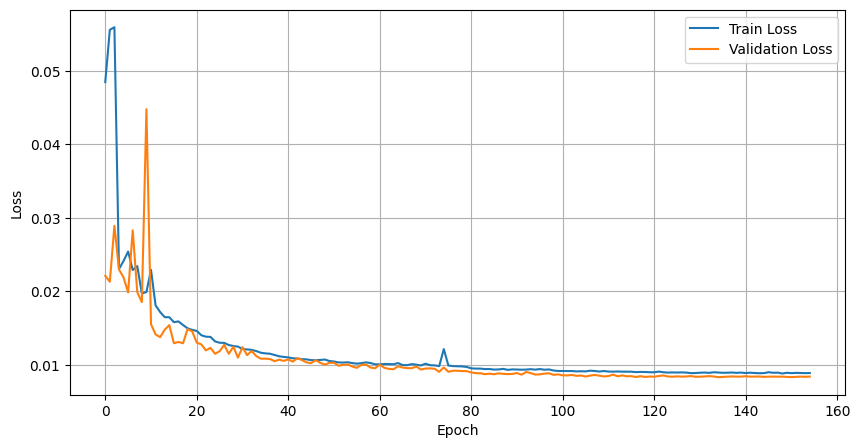

In [179]:
# TRAINING

if __name__ == "__main__":
    # Initialize model and config
    model = VAE()
    config = VAEConfig()

    # Train model
    train_losses, val_losses = train_vae(model, train_loader, val_loader, config)

In [41]:
# Cell 23: Model Evaluation and Reconstruction Visualization
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_trained_vae(checkpoint_dir, model_name='vae'):
    """Load trained VAE model and metadata"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Load model
    model = VAE()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, metadata

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes with added uncertainty visualization"""
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            # Generate multiple reconstructions to assess variance
            reconstructions = []
            for _ in range(5):  # Generate 5 reconstructions per sample
                recon, _, _ = model(volumes)
                reconstructions.append(recon.cpu().numpy())
            reconstructions = np.stack(reconstructions)

            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 8))

                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_mean = reconstructions[:, idx, 0].mean(axis=0)
                recon_std = reconstructions[:, idx, 0].std(axis=0)

                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[34, :, :],
                    orig_vol[:, 50, :],
                    orig_vol[:, :, 75]                    
                ]
                slices_recon = [
                    recon_mean[34, :, :],
                    recon_mean[:,50, :],
                    recon_mean[:, :, 75]
                ]
                slices_std = [
                    recon_std[34, :, :],
                    recon_std[:, 50, :],
                    recon_std[:, :, 75]
                ]

                for i, (view, orig_slice, recon_slice, std_slice) in enumerate(zip(views, slices_orig, slices_recon, slices_std)):
                    # Original
                    plt.subplot(3, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Original {view}')
                    plt.axis('off')

                    # Reconstructed
                    plt.subplot(3, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')

                    # Uncertainty
                    plt.subplot(3, 3, i+7)
                    plt.imshow(std_slice, cmap='viridis')
                    plt.title(f'Uncertainty {view}')
                    plt.colorbar()
                    plt.axis('off')

                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed with Uncertainty', y=1.02)
                plt.tight_layout()
                plt.show()

            break  # Only process first batch

In [185]:
# Cell 24: Quantitative Metrics
def compute_metrics(model, val_loader):
    """Compute quantitative metrics including reconstruction error and KL divergence"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss(reduction='none')

    total_mse = 0
    total_kl = 0
    total_samples = 0

    region_errors = {
        'Left Striatum': [],
        'Right Striatum': [],
        'Background': []
    }

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            recon, mu, log_var = model(volumes)

            # Overall MSE
            mse = mse_criterion(recon, volumes).mean(dim=(1,2,3,4))

            # KL divergence
            kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            total_mse += mse.sum().item()
            total_kl += kl.sum().item()
            total_samples += volumes.shape[0]

            # Region-specific analysis
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon_vol = recon[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon_vol[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

    # Calculate average metrics
    avg_mse = total_mse / total_samples
    avg_kl = total_kl / total_samples

    print(f"\nOverall Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average KL Divergence: {avg_kl:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

    print("\nRegion-Specific MSE:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

    return avg_mse, avg_kl, region_errors

In [43]:
# Cell 25: Latent Space Analysis
def analyze_latent_space(model, val_loader, num_samples=1000):
    """Analyze the structure of the learned latent space"""
    device = next(model.parameters()).device
    latent_vectors = []
    labels = []
    reconstructions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Collecting latent vectors"):
            volumes = batch['volume'].to(device)
            mu, log_var = model.encoder(volumes)
            z = model.reparameterize(mu, log_var)

            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            if len(np.concatenate(latent_vectors)) >= num_samples:
                break

    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels[:num_samples])

    # Plot latent space distribution
    plt.figure(figsize=(15, 5))

    # Plot distribution of first two dimensions
    plt.subplot(131)
    labels_categorical = pd.Categorical(labels).codes
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels_categorical, alpha=0.6)
    plt.title('First Two Latent Dimensions')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot average activation per dimension
    plt.subplot(132)
    avg_activation = np.mean(np.abs(latent_vectors), axis=0)
    plt.bar(range(len(avg_activation)), avg_activation)
    plt.title('Average Activation per Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Average Activation')

    # Plot variance explained
    plt.subplot(133)
    var_explained = np.var(latent_vectors, axis=0)
    plt.plot(np.cumsum(var_explained) / np.sum(var_explained))
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Cumulative Variance Ratio')

    plt.tight_layout()
    plt.show()

    return latent_vectors, labels


Computing metrics...


Computing metrics:   0%|          | 0/149 [00:00<?, ?it/s]


Overall Metrics:
Average MSE: 0.012616
Average KL Divergence: 0.004897
RMSE: 0.112319

Region-Specific MSE:

Left Striatum:
Mean MSE: 0.025839
Std MSE: 0.039198
Min MSE: 0.004647
Max MSE: 1.344174

Right Striatum:
Mean MSE: 0.026216
Std MSE: 0.039434
Min MSE: 0.004881
Max MSE: 1.339782

Background:
Mean MSE: 0.000034
Std MSE: 0.000000
Min MSE: 0.000033
Max MSE: 0.000035

Analyzing latent space...


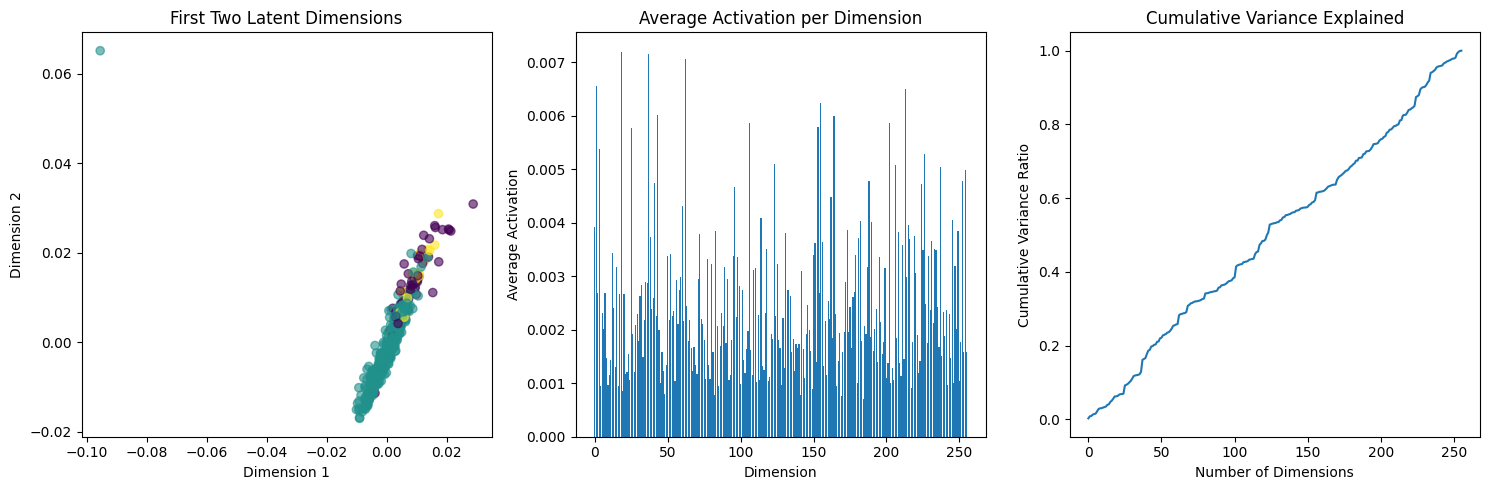

In [421]:
# Cell 26: Run Evaluation
if __name__ == "__main__":
    # Load trained model
    model, metadata = load_trained_vae('checkpoints',model_name='vae_Beta1e0')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

 #   print("Visualizing reconstructions...")
  #  visualize_reconstructions(model, val_loader)

    print("\nComputing metrics...")
    avg_mse, avg_kl, region_errors = compute_metrics(model, train_loader)

    print("\nAnalyzing latent space...")
    latent_vectors, labels = analyze_latent_space(model, val_loader,num_samples=10000)

Text(0, 0.5, 'beta*KL')

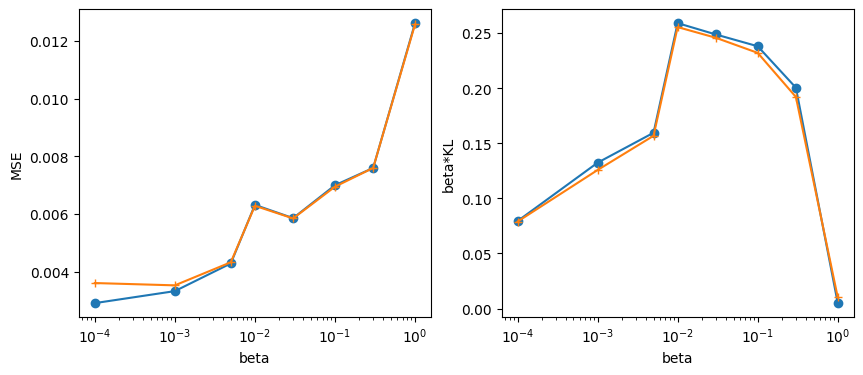

In [182]:
trainMSE = [0.002914,0.00333,0.00429,0.00632,0.00586,0.007,0.0076,0.01262]
trainKL = np.array([793.4,132.31,31.9,25.90,8.29,2.38,0.668,0.0049])
valMSE = [0.00361,0.00353,0.00433,0.006288,0.00585,0.00695,0.0076,0.01258]
valKL = np.array([788.6,125.7,31.35,25.54,8.19,2.32,0.64,0.0101])
betaV = np.array([1e-4,0.001,5e-3,0.01,0.03,0.1,0.3,1])
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(betaV,trainMSE,'o-')
plt.plot(betaV,valMSE,'+-')
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('MSE')
plt.subplot(122)
plt.plot(betaV,betaV*trainKL,'o-')
plt.plot(betaV,betaV*valKL,'+-')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('beta')
plt.ylabel('beta*KL')

#### Correlate with SBR

In [187]:
sbrVal = pd.read_csv('DaTScan_SBR_Analysis_17Dec2024.csv')

In [195]:
sbrVal['DATSCAN_DATE'] = pd.to_datetime(sbrVal['DATSCAN_DATE'])

In [203]:
sbrVal['PATNO']

0         3000
1         3001
2         3001
3         3001
4         3001
         ...  
4172    395282
4173    397443
4174    402314
4175    406452
4176    407230
Name: PATNO, Length: 4177, dtype: int64

In [197]:
for b in train_loader:
    break

In [216]:
sbrVal['DATSCAN_DATE']

0      2011-01-01
1      2011-06-01
2      2014-04-01
3      2012-04-01
4      2013-05-01
          ...    
4172   2024-10-01
4173   2024-10-01
4174   2024-11-01
4175   2024-11-01
4176   2024-11-01
Name: DATSCAN_DATE, Length: 4177, dtype: datetime64[ns]

In [221]:
sbrVal.head()

,PROTOCOL,PATNO,EVENT_ID,DATSCAN_LIGAND,DATSCAN_DATE,DATSCAN_CAUDATE_R,DATSCAN_CAUDATE_L,DATSCAN_PUTAMEN_R,DATSCAN_PUTAMEN_L,DATSCAN_PUTAMEN_R_ANT,DATSCAN_PUTAMEN_L_ANT,DATSCAN_ANALYZED,DATSCAN_NOT_ANALYZED_REASON,DATSCAN_OTHER_SPECIFY
0,001,3000,SC,NaN,2011-01-01,2.99,3.43,2.94,2.63,3.28,3.40,Yes,NaN,NaN
1,001,3001,U01,NaN,2011-06-01,2.00,1.92,0.80,0.65,1.51,1.06,Yes,NaN,NaN
2,001,3001,U02,NaN,2014-04-01,1.53,0.65,0.37,0.50,0.85,0.60,Yes,NaN,NaN
3,001,3001,V04,NaN,2012-04-01,1.56,1.12,0.62,0.48,0.91,0.74,Yes,NaN,NaN
4,001,3001,V06,NaN,2013-05-01,1.68,1.26,0.38,0.42,0.88,0.62,Yes,NaN,NaN


In [422]:
latent_vectors = []
labels = []
sbrVect = []
with torch.no_grad():
  #  nBPr = 0
    for batch in tqdm(train_loader, desc="Collecting latent vectors"):
        volumes = batch['volume'].to(device)
        mu, log_var = model.encoder(volumes)
       # print('and 1',end='\t')
        batchSBR = []
        batchLatVect = []
        muVect = mu.cpu().numpy()        
        for bIdx,sPath in enumerate(batch['path']):
            path_parts = sPath.strip().split("/")
            date = path_parts[6]
            id_ = path_parts[4] 
            dfPat = sbrVal[sbrVal['PATNO']==int(id_)]            
            row = dfPat[dfPat['DATSCAN_DATE']==pd.to_datetime(date[:7])]
            if len(row)!=1:
                continue
            batchSBR.append(row[['DATSCAN_CAUDATE_L','DATSCAN_CAUDATE_R','DATSCAN_PUTAMEN_R','DATSCAN_PUTAMEN_L','DATSCAN_PUTAMEN_R_ANT','DATSCAN_PUTAMEN_L_ANT']].values)
            batchLatVect.append(muVect[bIdx,:])
     #   print(muVect.shape,end='\t')
    #    print(np.concatenate(batchSBR).shape)
     #   if muVect.shape[0] != len(batchSBR):
    #        print(
        latent_vectors.append(np.array(batchLatVect))
        sbrVect.append(np.concatenate(batchSBR))
#        nBPr +=1
    #    if nBPr>100:
    #        break
        #labels.extend(batch['label'])
        



In [423]:
sbrVect = np.concatenate(sbrVect)
latent_vectors = np.concatenate(latent_vectors)

In [424]:
sbrVect.shape, latent_vectors.shape

((2370, 6), (2370, 256))

In [425]:
#plt.figure(figsize=(20,10))
corrM=(np.corrcoef(sbrVect.T,latent_vectors.T)[:6,6:]**2)

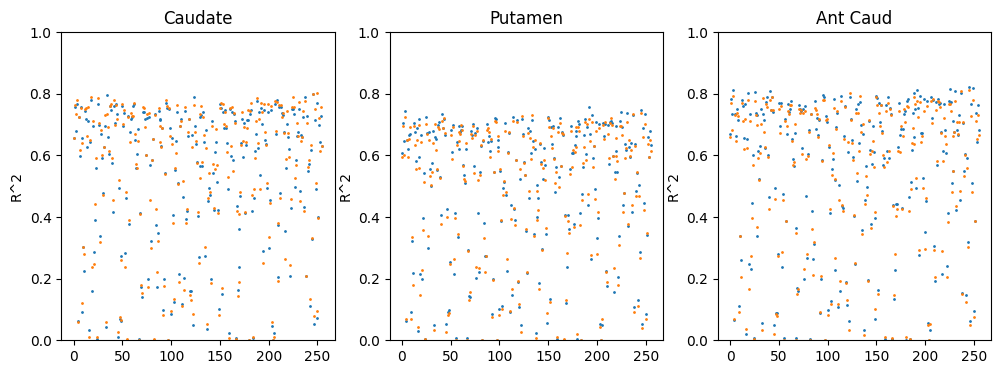

In [426]:
plt.figure(figsize=(12,4))
roiL = ['Caudate','Putamen','Ant Caud']
for pIdx in range(3):
    plt.subplot(1,3,pIdx+1)
    plt.plot(corrM[(pIdx)*2:(pIdx+1)*2,:].T,'o ',markersize=1)
    plt.ylim(0,1)
    plt.ylabel('R^2')
    plt.title(roiL[pIdx])


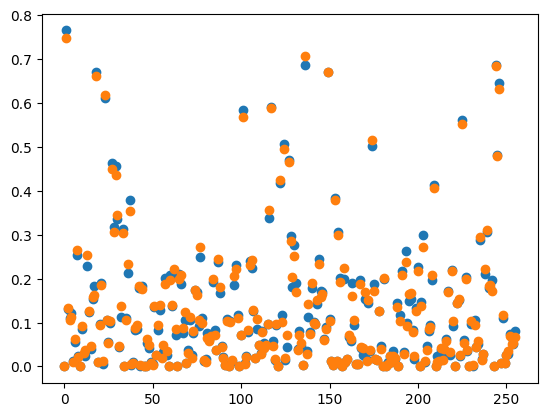

In [377]:
plt.plot(corrM[2:4,:].T,'o ')

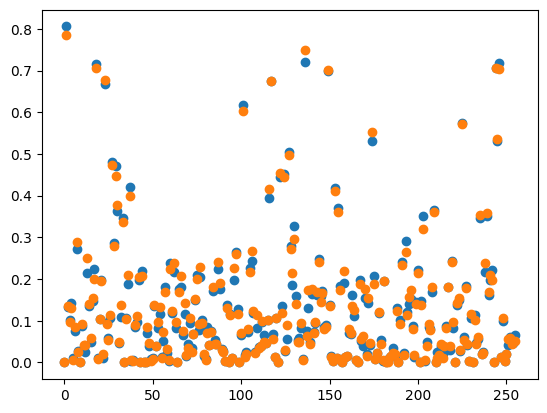

In [378]:
plt.plot(corrM[4:,:].T,'o ')

(10.0, 20.0)

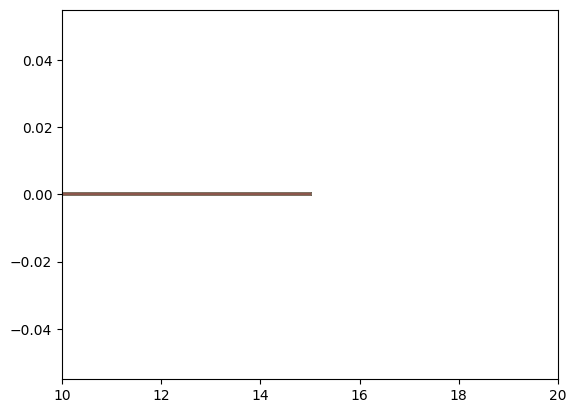

In [314]:
plt.plot(np.std(latent_vectors,axis=0))
plt.xlim(10,20)

<Axes: >

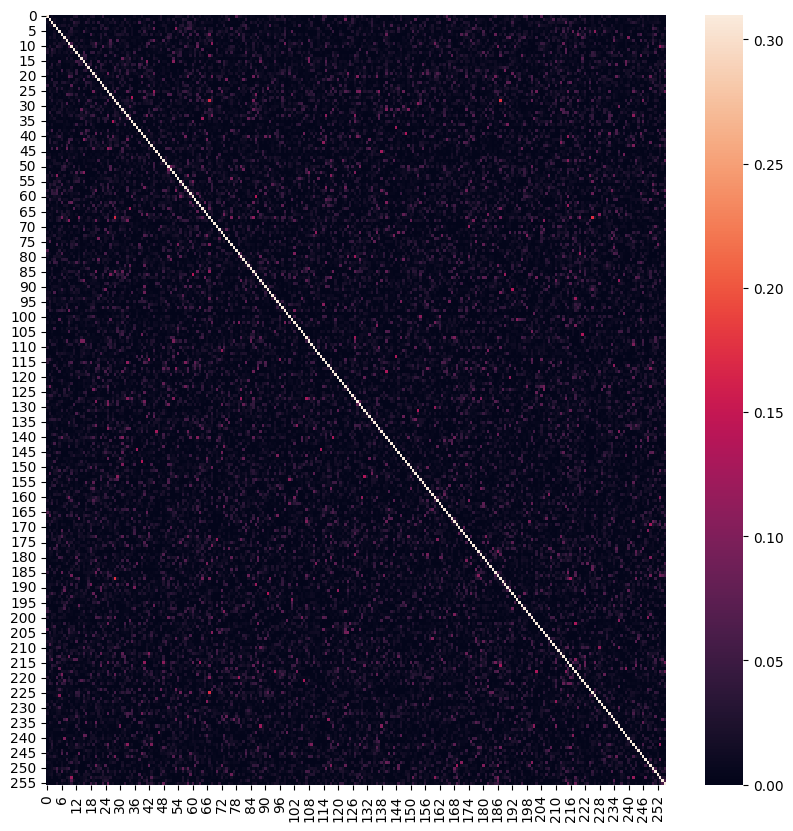

In [135]:
plt.figure(figsize=(10,10))
sns.heatmap(np.corrcoef(latent_vectors.T)**2,vmin=0.,vmax=.31)